# Team Based Model

## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.data.make_team_dataset import load_team_data


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb


from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix

import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
print('skopt %s' % skopt.__version__)

In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-

skopt 0.8.1


In [2]:
pd.options.display.max_columns=230
pd.options.display.max_rows=100

## Gather Team Level Basic, Advanced, and Scoring Data

In [3]:
team_data = load_team_data()

In [4]:
from src.data.make_team_dataset import clean_team_data

clean_team_df = clean_team_data(team_data)

In [5]:
clean_team_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,HOME_GAME
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,0,240,34,74,0.459,2,9,0.222,28,40,0.700,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,0.529,1.00,14.1,0.289,0.667,0.478,18.256,18.9,0.473,0.535,1.0,0.197,98.32,95.5,79.58,95.0,0.446,0.878,0.122,0.653,0.163,0.061,0.102,0.286,0.204,0.490,0.563,0.438,0.000,1.000,0.529,0.471,1
1,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,1,240,43,88,0.489,6,11,0.545,14,16,0.875,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,0.674,1.81,20.7,0.333,0.711,0.522,16.320,16.7,0.523,0.558,1.0,0.195,98.32,95.5,79.58,96.0,0.554,0.875,0.125,0.698,0.396,0.170,0.085,0.132,0.208,0.302,0.622,0.378,1.000,0.000,0.674,0.326,0
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,0,240,31,85,0.365,3,10,0.300,17,26,0.654,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,0.774,1.60,17.7,0.276,0.698,0.477,15.084,15.3,0.382,0.425,1.0,0.196,99.76,98.0,81.67,98.0,0.488,0.882,0.118,0.683,0.171,0.110,0.110,0.207,0.256,0.512,0.750,0.250,1.000,0.000,0.774,0.226,1
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,1,240,32,78,0.410,2,7,0.286,20,32,0.625,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,0.500,0.84,12.6,0.302,0.724,0.523,18.985,19.4,0.423,0.467,1.0,0.202,99.76,98.0,81.67,98.0,0.512,0.910,0.090,0.698,0.279,0.070,0.163,0.233,0.140,0.419,0.467,0.533,1.000,0.000,0.500,0.500,0
4,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,240,36,80,0.450,4,17,0.235,9,13,0.692,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,0.528,1.12,15.6,0.239,NaN,NaN,18.139,18.1,0.475,0.496,1.0,0.199,93.06,94.0,78.33,94.0,0.359,0.788,0.213,0.753,0.447,0.141,0.106,0.106,0.259,0.306,0.469,0.531,1.000,0.000,0.528,0.472,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51343,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,1,240,35,79,0.443,14,39,0.359,18,21,0.857,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,0.714,1.67,19.5,0.289,0.783,0.538,16.088,16.3,0.532,0.578,1.0,0.200,93.84,92.0,76.67,92.0,0.559,0.506,0.494,0.412,0.078,0.412,0.069,0.176,0.186,0.333,0.619,0.381,0.857,0.143,0.714,0.286,0
51344,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,1,240,38,83,0.458,14,33,0.424,21,22,0.955,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,0.684,2.00,19.7,0.267,0.667,0.467,13.446,14.0,0.542,0.599,1.0,0.199,95.46,93.5,77.92,93.0,0.512,0.602,0.398,0.432,0.144,0.378,0.036,0.189,0.180,0.288,0.542,0.458,0.929,0.071,0.684,0.316,0
51345,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900405,2020-10-09,LAL vs. MIA,0,240,38,82,0.463,14,38,0.368,18,21,0.857,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,119.4,-0.2,-4.5,0.553,1.40,16.5,0.333,0.733,0.533,15.917,16.0,0.549,0.592,1.0,0.200,95.46,93.5,77.92,94.0,0.488,0.537,0.463,0.444,0.056,0.389,0.231,0.167,0.130,0.389,0.458,0.542,0.714,0.286,0.553,0.447,1
51346,2019-20,42019,1610612748,MIA,Miami Heat,41900406,2020-10-11,MIA vs. LAL,0,240,35,79,0.443,10,28,0.357,13,22,0.591,9,32,41,25,4,4,15,18,93,-13,98.2,100.0,109.1,112.8,-

In [6]:
from src.data.make_team_dataset import prep_for_aggregation
ready_for_agg_df = prep_for_aggregation(clean_team_df)
ready_for_agg_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,point_diff,WL,MIN,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,POSS,PIE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2
1,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0
4,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,85,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51343,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,0,102,6,1,240,1,21,40,14,39,18,21,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,92.0,0.559,7,7,18,33,12,8,11,2
51344,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,0,111,3,1,240,1,24,50,14,33,21,22,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,93.0,0.512,15,3,19,31,13,10,13,0
51345,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900405,2020-10-09,LAL vs. MIA,1,108,-3,0,240,0,24,44,14,38,18,21,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,119.4,-0.2,-4.5,94.0,0.488,6,24,14,42,10,13,9,4
51346,2019-20,42019,1610612748,MIA,Miami Heat,41900406,2020-10-11,MIA vs. LAL,1,93,-13,0,240,0,25,51,10,28,13,22,9,32,41,25,4,4,15,18,93,-13,98.2,100.0,109.1,112.8,-10.9,-12.8,93.0,0.456,6,7,14,43,18,7,7,3


In [7]:
from src.data.make_team_dataset import create_matchups

matchups = create_matchups(ready_for_agg_df)

matchups

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,SEASON_YEAR_opp,SEASON_ID_opp,TEAM_ID_opp,TEAM_ABBREVIATION_opp,TEAM_NAME_opp,GAME_DATE_opp,MATCHUP_opp,HOME_GAME_opp,TEAM_SCORE_opp,point_diff_opp,WL_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0
2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0,2000-01,22000,1610612745,HOU,Houston Rockets,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2
5,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0
6,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0,2000-01,22000,1610612751,BKN,New Jersey Nets,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0
9,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,85,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0,2000-01,22000,1610612759,SAS,San Antonio Spurs,2000-10-31,SAS vs. IND,1,98,13,1,240,1,29,56,4,8,28,35,5,32,37,17,6,4,18,22,98,13,106.1,104.3,90.7,90.4,15.4,13.8,94.0,0.641,42,5,14,15,12,16,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102678,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,0,102,6,1,240,1,21,40,14,39,18,21,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,92.0,0.559,7,7,18,33,12,8,11,2,2019-20,42019,1610612748,MIA,Miami Heat,2020-10-06,MIA vs. LAL,1,96,-6,0,240,0,21,43,11,32,21,26,7,32,39,18,8,3,15,21,96,-6,101.7,104.3,109.4,110.9,-7.7,-6.5,92.0,0.441,9,4,12,31,6,14,11,0
102681,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,0,111,3,1,240,1,24,50,14,33,21,22,9,26,35,26,7,3,13,19,111

In [8]:
from src.data.make_team_dataset import get_team_and_opp_avg
avg_data = get_team_and_opp_avg(matchups)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.23it/s]


In [9]:
avg_data

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,TEAM_SCORE_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000023,2000-11-02,HOU vs. MIL,1,115,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01,22000,1610612745,HOU,Houston Rockets,20000044,2000-11-04,HOU @ LAC,0,74,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01,22000,1610612745,HOU,Houston Rockets,20000048,2000-11-05,HOU @ PHX,0,99,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01,22000,1610612745,HOU,Houston Rockets,20000058,2000-11-07,HOU vs. LAL,1,84,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51339,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901268,2020-08-06,NOP @ SAC,0,125,-15,0,242.5,0.4,31.5,59.5,11.1,33.0,17.9,26.0,11.8,37.3,49.1,28.3,8.7,3.4,17.8,20.9,114.2,-1.0,103.95,107.11,105.67,107.63,-1.74,-0.51,106.6,0.5058,7.8,17.2,15.6,54.5,17.8,12.8,9.5,0.9,115.2,242.5,0.6,28.6,54.6,13.5,38.4,17.5,22.7,9.3,34.0,43.3,25.0,9.3,6.9,15.3,22.7,115.2,1.0,105.67,107.63,103.95,107.11,1.74,0.51,107.0,0.4942,6.1,17.0,21.0,50.7,14.4,13.5,9.8,3.1
51340,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901278,2020-08-07,NOP vs. WAS,1,118,11,1,242.5,0.4,31.7,58.4,11.7,33.7,17.3,25.3,11.7,35.9,47.6,28.3,8.1,3.5,17.5,21.1,115.8,-1.6,106.33,109.58,108.91,110.73,-2.60,-1.14,105.7,0.5030,8.5,14.6,14.7,54.4,17.2,13.6,10.1,0.8,117.4,242.5,0.6,28.8,54.8,13.8,37.3,18.4,23.9,9.2,32.9,42.1,24.9,9.4,6.0,14.5,22.7,117.4,1.6,108.91,110.73,106.33,109.58,2.60,1.14,10

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [10]:
from src.features.build_team_features import add_rest_days
from src.features.build_team_features import add_percentage_features


In [11]:
avg_data_2 = add_percentage_features(avg_data)
avg_data_3 = add_rest_days(avg_data_2)
avg_data_3

..\src\features\build_team_features.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['rest'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')


,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,OREB_PCT_team,DREB_PCT_team,REB_PCT_team,TS_PCT_team,EFG_PCT_team,AST_RATIO_team,TOV_PCT_team,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_opp,DREB_PCT_opp,REB_PCT_opp,TS_PCT_opp,EFG_PCT_opp,AST_RATIO_opp,TOV_PCT_opp,rest
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000023,2000-11-02,HOU vs. MIL,1,115,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,2000-01,22000,1610612745,HOU,Houston Rockets,20000044,2000-11-04,HOU @ LAC,0,74,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2000-01,22000,1610612745,HOU,Houston Rockets,20000048,2000-11-05,HOU @ PHX,0,99,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,2000-01,22000,1610612745,HOU,Houston Rockets,20000058,2000-11-07,HOU vs. LAL,1,84,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51339,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901268,2020-08-06,NOP @ SAC,0,125,-15,0,242.5,0.4,31.5,59.5,11.1,33.0,17.9,26.0,11.8,37.3,49.1,28.3,8.7,3.4,17.8,20.9,114.2,-1.0,103.95,107.11,105.67,107.63,-1.74,-0.51,106.6,0.5058,7.8,17.2,15.6,54.5,17.8,12.8,9.5,0.9,0.257642,0.800429,0.531385,0.581348,0.520541,26.547842,14.621324,242.5,0.6,28.6,54.6,1

In [12]:
avg_data_3 = avg_data_3.dropna()
        

In [13]:
home_teams = avg_data_3.loc[avg_data_3['HOME_GAME_team'] == 1]
away_teams = avg_data_3.loc[avg_data_3['HOME_GAME_team'] == 0]
away_teams = away_teams.drop(columns = ['GAME_DATE_team',
                                        'SEASON_YEAR_team',
                                        'SEASON_ID_team',
                                        'TEAM_ID_team',
                                        'TEAM_ABBREVIATION_team',
                                        'TEAM_NAME_team',
                                        'GAME_DATE_team',
                                        'MATCHUP_team',
                                        'HOME_GAME_team',
                                        'point_diff_team',
                                        'WL_team'])

full_df = pd.merge(home_teams, away_teams, on='GAME_ID')
full_df = full_df.dropna()

new_cols = []
for col in full_df.columns:
    if col.endswith('_x'):
        col = 'HOME_' + col[:-2]
    if col.endswith('_y'):
        col = 'AWAY_' + col[:-2]
    if col.endswith('_team'):
        col = col[:-5]
        
    new_cols.append(col)
    
full_df.columns = new_cols


columns = full_df.columns.tolist()
columns.remove('AWAY_TEAM_SCORE')
columns.insert(10, 'AWAY_TEAM_SCORE')

full_df = full_df[columns]

In [14]:
full_df = full_df.sort_values('GAME_DATE').reset_index(drop=True)
full_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,WL,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000076,2000-11-09,HOU vs. MEM,1,85,78,7,1,240.0,0.4,26.8,59.4,5.8,16.2,23.0,29.4,11.8,27.4,39.2,19.0,8.6,4.2,16.6,22.0,94.0,3.2,100.72,103.16,98.42,99.20,2.28,3.94,91.0,0.5110,18.0,7.0,18.2,34.6,14.2,12.0,4.6,1.0,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,240.0,0.6,29.6,62.0,4.8,13.2,17.2,24.0,10.2,28.8,39.0,20.4,6.6,4.4,16.6,23.0,90.8,-3.2,98.42,99.20,100.72,103.16,-2.28,-3.94,91.4,0.4890,23.2,7.8,17.6,35.2,15.6,13.4,4.4,0.2,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0,240.0,0.8,31.4,69.8,3.6,12.0,22.4,30.4,12.8,32.4,45.2,22.8,9.8,3.8,16.2,24.0,96.0,8.4,97.46,99.48,90.12,90.34,7.36,9.12,96.6,0.5760,25.6,9.8,20.8,36.0,19.0,11.8,3.4,0.2,0.292237,0.710526,0.505593,0.542446,0.449878,23.602484,14.545324,240.0,0.2,30.6,67.8,3.6,13.2,15.6,23.0,13.2,31.0,44.2,18.0,8.6,8.0,19.4,25.2,87.6,-8.4,90.12,90.34,97.46,99.48,-7.36,-9.12,97.0,0.4240,15.4,10.4,16.2,44.6,14.8,15.2,2.8,0.6,0.289474,0.707763,0.494407,0.508947,0.444444,18.556701,17.553384,1.0
1,2000-01,22000,1610612757,POR,Portland Trail Blazers,20000078,2000-11-09,POR vs. DEN,1,107,91,16,1,240.0,0.4,31.0,69.6,4.2,12.6,12.8,16.0,13.6,29.0,42.6,23.4,7.8,7.6,17.6,25.8,87.4,-4.8,93.64,94.84,99.02,100.98,-5.40,-6.12,92.0,0.4580,24.6,16.0,17.2,36.6,19.2,11.2,3.8,0.4,0.323810,0.710784,0.514493,0.509799,0.453771,25.434783,16.473231,240.0,0.6,29.8,62.6,4.2,14.8,20.0,27.0,11.8,28.4,40.2,23.0,9.2,5.0,15.6,19.0,92.2,4.8,99.02,100.98,93.

In [15]:
abs(full_df['point_diff']).mean()

10.969488148117398

## Add ELO Rating

In [16]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    
    # If the home team wins
    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(home_score, away_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_home, S_away = 0, 0
    if home_score > away_score:
        S_home = 1
    else:
        S_away = 1
    return S_home, S_away


def elo_prediction(home_rating, away_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_home = 1.0/(1 + 10 ** ((away_rating - home_rating) / (400.0)))
    return E_home


def elo_update(home_score, away_score, home_rating, away_rating):
    # Add 100 to the home_rating for home court advantage
    HOME_AD = 100
    home_rating += HOME_AD
    
    
    E_home = elo_prediction(home_rating, away_rating)
    E_away = 1.0 - E_home
    
    MOV = home_score - away_score
    
    if MOV > 0:
        elo_diff = home_rating - away_rating
    else:
        elo_diff = away_rating - home_rating
        
    
    S_home, S_away = get_S(home_score, away_score)
    
    K_home, K_away = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_home, E_away)
#     print("elo_diff:", elo_diff)
#     print("S_home:", S_home, "S_away:", S_away)
#     print("K_home:", K_home, "K_away:", K_away)
#     print(K_home*(S_home-E_home), K_away*(S_away-E_away))
    return K_home*(S_home-E_home), K_away*(S_away-E_away)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [17]:
def get_elo_ratings(df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON_YEAR'] != df.loc[idx-1, 'SEASON_YEAR']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

        if row['TEAM_ABBREVIATION'] not in elo_dic:
            elo_dic[row['TEAM_ABBREVIATION']] = 1300
            df.loc[idx, 'home_rating_i'] = 1300
        else:
            df.loc[idx, 'home_rating_i'] = elo_dic[row['TEAM_ABBREVIATION']]

        away_team_abbr = row['MATCHUP'][-3:]
        if away_team_abbr not in elo_dic:
            elo_dic[away_team_abbr] = 1300
            df.loc[idx, 'away_rating_i'] = 1300
        else:
            df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['HOME_TEAM_SCORE']
        away_score = row['AWAY_TEAM_SCORE']
        home_rating = elo_dic[row['TEAM_ABBREVIATION']]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[row['TEAM_ABBREVIATION']] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return None

get_elo_ratings(full_df)

progress:: 24089it [00:41, 574.87it/s]


In [18]:
full_df[['MATCHUP', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'home_rating_i', 'away_rating_i',
        'home_rating_n', 'away_rating_n', 'home_elo_pred']]

,MATCHUP,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,home_rating_i,away_rating_i,home_rating_n,away_rating_n,home_elo_pred
0,HOU vs. MEM,85,78,1300.000000,1300.000000,1305.607497,1294.392503,0.640065
1,POR vs. DEN,107,91,1300.000000,1300.000000,1309.370698,1290.629302,0.640065
2,CHA vs. OKC,94,102,1300.000000,1300.000000,1289.238242,1310.761758,0.640065
3,PHX vs. ATL,88,79,1300.000000,1300.000000,1306.488048,1293.511952,0.640065
4,MIN vs. PHI,82,84,1300.000000,1300.000000,1294.272764,1305.727236,0.640065
...,...,...,...,...,...,...,...,...
24084,LAL vs. MIA,124,114,1699.423214,1651.770060,1704.981562,1646.211713,0.700559
24085,MIA vs. LAL,115,104,1646.211713,1704.981562,1655.612387,1695.580887,0.559058
24086,MIA vs. LAL,96,102,1655.612387,1695.580887,1646.971674,1704.221600,0.585543
24087,LAL vs. MIA,108,111,1704.221600,1646.971674,1697.149975,1654.043299,0.712018


## Add Betting Data

In [19]:
spread_df = pd.read_csv('../data/all_spreads_sbr.csv', parse_dates=['game_date'])


spread_df


,away_team,home_team,game_date,away_scoreboard,home_scoreboard,away_spread,home_spread
0,Chicago,Miami,2006-10-31,"'22', '37', '21', '28', '108'","'16', '14', '21', '15', '66'","'+4½-110', '-', '+4½-110', '-'","'-4½-110', '-', '-4½-110', '-'"
1,Phoenix,L.A. Lakers,2006-10-31,"'41', '17', '21', '27', '106'","'26', '27', '34', '27', '114'","'-8½-110', '-', '-8-110', '-'","'+8½-110', '-', '+8-110', '-'"
2,Atlanta,Philadelphia,2006-11-01,"'14', '21', '23', '17', '75'","'29', '20', '24', '15', '88'","'+6-115', '-', '+5½-110', '-'","'-6-105', '-', '-5½-110', '-'"
3,New Orleans,Boston,2006-11-01,"'26', '28', '21', '16', '91'","'16', '25', '24', '22', '87'","'+3½-110', '-', '+3-110', '-'","'-3½-110', '-', '-3-110', '-'"
4,Toronto,Brooklyn,2006-11-01,"'27', '22', '21', '22', '92'","'28', '25', '21', '28', '102'","'+7-110', '-', '+7½-110', '-'","'-7-110', '-', '-7½-110', '-'"
...,...,...,...,...,...,...,...
18225,Golden State,Portland,2021-03-03,"'29', '27', '24', '26', '106'","'28', '27', '27', '26', '108'","'-5½-120', '-1-115', '-1-115', '-1-108'","'+5½-120', '+1-105', '+1-105', '+1-108'"
18226,Chicago,New Orleans,2021-03-03,"'26', '38', '32', '32', '128'","'25', '20', '34', '45', '124'","'+6-115', '+6-110', '+6-110', '+6-108'","'-6-105', '-6-110', '-6-110', '-6-108'"
18227,Oklahoma City,Dallas,2021-03-03,"'23', '19', '19', '17', '78'","'25', '24', '26', '12', '87'","'+5½-115', '+5½-110', '+5-110', '+5-108'","'-5½-105', '-5½-110', '-5-110', '-5-108'"
18228,Charlotte,Minnesota,2021-03-03,"'36', '26', '36', '37', '135'","'33', '23', '20', '26', '102'","'-3-115', '-2½-105', '-2-110', '-2½-108'","'+3-105', '+2½-115', '+2-110', '+2½-108'"


In [20]:
from src.data.make_betting_dataset import clean_spread_data

clean_spread = clean_spread_data(spread_df)

In [21]:
clean_spread

,away_team,home_team,game_date,away_scoreboard,home_scoreboard,away_spread1,away_spread2,away_spread3,away_spread4,home_spread1,home_spread2,home_spread3,home_spread4,away_spread_mode,home_spread_mode
0,CHI,MIA,2006-10-31,"'22', '37', '21', '28', '108'","'16', '14', '21', '15', '66'",4.5,NaN,4.5,NaN,-4.5,NaN,-4.5,NaN,4.5,-4.5
1,PHX,LAL,2006-10-31,"'41', '17', '21', '27', '106'","'26', '27', '34', '27', '114'",-8.5,NaN,-8.0,NaN,8.5,NaN,8.0,NaN,-8.5,8.0
2,ATL,PHI,2006-11-01,"'14', '21', '23', '17', '75'","'29', '20', '24', '15', '88'",6.0,NaN,5.5,NaN,-6.0,NaN,-5.5,NaN,5.5,-6.0
3,NOP,BOS,2006-11-01,"'26', '28', '21', '16', '91'","'16', '25', '24', '22', '87'",3.5,NaN,3.0,NaN,-3.5,NaN,-3.0,NaN,3.0,-3.5
4,TOR,BKN,2006-11-01,"'27', '22', '21', '22', '92'","'28', '25', '21', '28', '102'",7.0,NaN,7.5,NaN,-7.0,NaN,-7.5,NaN,7.0,-7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18225,GSW,POR,2021-03-03,"'29', '27', '24', '26', '106'","'28', '27', '27', '26', '108'",-5.5,-1.0,-1.0,-1.0,5.5,1.0,1.0,1.0,-1.0,1.0
18226,CHI,NOP,2021-03-03,"'26', '38', '32', '32', '128'","'25', '20', '34', '45', '124'",6.0,6.0,6.0,6.0,-6.0,-6.0,-6.0,-6.0,6.0,-6.0
18227,OKC,DAL,2021-03-03,"'23', '19', '19', '17', '78'","'25', '24', '26', '12', '87'",5.5,5.5,5.0,5.0,-5.5,-5.5,-5.0,-5.0,5.0,-5.5
18228,CHA,MIN,2021-03-03,"'36', '26', '36', '37', '135'","'33', '23', '20', '26', '102'",-3.0,-2.5,-2.0,-2.5,3.0,2.5,2.0,2.5,-2.5,2.5


In [22]:
clean_spread_relevant = clean_spread[['away_team', 'home_team', 'game_date', 'away_spread_mode', 'home_spread_mode']]
clean_spread_relevant

,away_team,home_team,game_date,away_spread_mode,home_spread_mode
0,CHI,MIA,2006-10-31,4.5,-4.5
1,PHX,LAL,2006-10-31,-8.5,8.0
2,ATL,PHI,2006-11-01,5.5,-6.0
3,NOP,BOS,2006-11-01,3.0,-3.5
4,TOR,BKN,2006-11-01,7.0,-7.5
...,...,...,...,...,...
18225,GSW,POR,2021-03-03,-1.0,1.0
18226,CHI,NOP,2021-03-03,6.0,-6.0
18227,OKC,DAL,2021-03-03,5.0,-5.5
18228,CHA,MIN,2021-03-03,-2.5,2.5


In [23]:
moneyline_df = pd.read_csv("../data/all_moneylines_sbr.csv", parse_dates=['game_date'])
moneyline_df

,away_team,home_team,game_date,away_moneyline,home_moneyline
0,Chicago,Miami,2006-10-31,"'+180', '-', '+180', '-'","'-220', '-', '-210', '-'"
1,Phoenix,L.A. Lakers,2006-10-31,"'-380', '-', '-350', '-'","'+290', '-', '+290', '-'"
2,Sacramento,Minnesota,2006-11-01,"'+190', '-', '+180', '-'","'-230', '-', '-210', '-'"
3,Atlanta,Philadelphia,2006-11-01,"'+200', '-', '+200', '-'","'-240', '-', '-240', '-'"
4,New Orleans,Boston,2006-11-01,"'+140', '-', '+140', '-'","'-160', '-', '-160', '-'"
...,...,...,...,...,...
18239,Detroit,Toronto,2021-03-03,"'+255', '+260', '+267', '+265'","'-310', '-310', '-331', '-325'"
18240,Utah,Philadelphia,2021-03-03,"'-155', '-165', '-145', '-150'","'+135', '+145', '+125', '+130'"
18241,Indiana,Cleveland,2021-03-03,"'-270', '-215', '-250', '-260'","'+220', '+185', '+207', '+210'"
18242,L.A. Lakers,Sacramento,2021-03-03,"'+165', '+158', '+163', '+160'","'-190', '-178', '-190', '-185'"


In [24]:
from src.data.make_betting_dataset import clean_moneyline_data

clean_ml = clean_moneyline_data(moneyline_df)

clean_ml

,away_team,home_team,game_date,away_ml1,away_ml2,away_ml3,away_ml4,home_ml1,home_ml2,home_ml3,home_ml4
0,CHI,MIA,2006-10-31,+180,NaN,+180,NaN,-220,NaN,-210,NaN
1,PHX,LAL,2006-10-31,-380,NaN,-350,NaN,+290,NaN,+290,NaN
2,SAC,MIN,2006-11-01,+190,NaN,+180,NaN,-230,NaN,-210,NaN
3,ATL,PHI,2006-11-01,+200,NaN,+200,NaN,-240,NaN,-240,NaN
4,NOP,BOS,2006-11-01,+140,NaN,+140,NaN,-160,NaN,-160,NaN
...,...,...,...,...,...,...,...,...,...,...,...
18239,DET,TOR,2021-03-03,+255,+260,+267,+265,-310,-310,-331,-325
18240,UTA,PHI,2021-03-03,-155,-165,-145,-150,+135,+145,+125,+130
18241,IND,CLE,2021-03-03,-270,-215,-250,-260,+220,+185,+207,+210
18242,LAL,SAC,2021-03-03,+165,+158,+163,+160,-190,-178,-190,-185


In [25]:
def convert_american_to_decimal(x):
    if type(x) == str:
        if x[0] == '+':
            return 1 + (int(x[1:]) / 100)
        else:
            return 1 + (100 / int(x[1:])) 
    else:
        return x
    
for col in clean_ml.columns[3:]:
    name = col[:-3] + 'decimal' + col[-1]
    clean_ml[name] = clean_ml[col].apply(convert_american_to_decimal)
    
clean_ml['away_decimal_avg'] = clean_ml[['away_decimal1', 'away_decimal2', 'away_decimal3', 'away_decimal4']].mean(axis=1, skipna=True)
clean_ml['home_decimal_avg'] = clean_ml[['home_decimal1', 'home_decimal2', 'home_decimal3', 'home_decimal4']].mean(axis=1, skipna=True) 
    
clean_ml

,away_team,home_team,game_date,away_ml1,away_ml2,away_ml3,away_ml4,home_ml1,home_ml2,home_ml3,home_ml4,away_decimal1,away_decimal2,away_decimal3,away_decimal4,home_decimal1,home_decimal2,home_decimal3,home_decimal4,away_decimal_avg,home_decimal_avg
0,CHI,MIA,2006-10-31,+180,NaN,+180,NaN,-220,NaN,-210,NaN,2.800000,NaN,2.800000,NaN,1.454545,NaN,1.476190,NaN,2.800000,1.465368
1,PHX,LAL,2006-10-31,-380,NaN,-350,NaN,+290,NaN,+290,NaN,1.263158,NaN,1.285714,NaN,3.900000,NaN,3.900000,NaN,1.274436,3.900000
2,SAC,MIN,2006-11-01,+190,NaN,+180,NaN,-230,NaN,-210,NaN,2.900000,NaN,2.800000,NaN,1.434783,NaN,1.476190,NaN,2.850000,1.455487
3,ATL,PHI,2006-11-01,+200,NaN,+200,NaN,-240,NaN,-240,NaN,3.000000,NaN,3.000000,NaN,1.416667,NaN,1.416667,NaN,3.000000,1.416667
4,NOP,BOS,2006-11-01,+140,NaN,+140,NaN,-160,NaN,-160,NaN,2.400000,NaN,2.400000,NaN,1.625000,NaN,1.625000,NaN,2.400000,1.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18239,DET,TOR,2021-03-03,+255,+260,+267,+265,-310,-310,-331,-325,3.550000,3.600000,3.670000,3.650000,1.322581,1.322581,1.302115,1.307692,3.617500,1.313742
18240,UTA,PHI,2021-03-03,-155,-165,-145,-150,+135,+145,+125,+130,1.645161,1.606061,1.689655,1.666667,2.350000,2.450000,2.250000,2.300000,1.651886,2.337500
18241,IND,CLE,2021-03-03,-270,-215,-250,-260,+220,+185,+207,+210,1.370370,1.465116,1.400000,1.384615,3.200000,2.850000,3.070000,3.100000,1.405026,3.055000
18242,LAL,SAC,2021-03-03,+165,+158,+163,+160,-190,-178,-190,-185,2.650000,2.580000,2.630000,2.600000,1.526316,1.561798,1.526316,1.540541,2.615000,1.538742


In [26]:
clean_ml_relevant = clean_ml[['away_team', 'home_team', 'game_date', 'away_decimal_avg', 'home_decimal_avg']]
clean_ml_relevant

,away_team,home_team,game_date,away_decimal_avg,home_decimal_avg
0,CHI,MIA,2006-10-31,2.800000,1.465368
1,PHX,LAL,2006-10-31,1.274436,3.900000
2,SAC,MIN,2006-11-01,2.850000,1.455487
3,ATL,PHI,2006-11-01,3.000000,1.416667
4,NOP,BOS,2006-11-01,2.400000,1.625000
...,...,...,...,...,...
18239,DET,TOR,2021-03-03,3.617500,1.313742
18240,UTA,PHI,2021-03-03,1.651886,2.337500
18241,IND,CLE,2021-03-03,1.405026,3.055000
18242,LAL,SAC,2021-03-03,2.615000,1.538742


In [27]:
all_bets_df = pd.merge(clean_spread_relevant, clean_ml_relevant, 
                       how='left', on = ['away_team', 'home_team', 'game_date'])

# all_bets_df.drop(columns = ['away_team', 'home_team', 'game_date'], inplace=True)
                       
                       

In [28]:
all_bets_df

,away_team,home_team,game_date,away_spread_mode,home_spread_mode,away_decimal_avg,home_decimal_avg
0,CHI,MIA,2006-10-31,4.5,-4.5,2.800000,1.465368
1,PHX,LAL,2006-10-31,-8.5,8.0,1.274436,3.900000
2,ATL,PHI,2006-11-01,5.5,-6.0,3.000000,1.416667
3,NOP,BOS,2006-11-01,3.0,-3.5,2.400000,1.625000
4,TOR,BKN,2006-11-01,7.0,-7.5,3.750000,1.307692
...,...,...,...,...,...,...,...
18225,GSW,POR,2021-03-03,-1.0,1.0,1.861331,1.965368
18226,CHI,NOP,2021-03-03,6.0,-6.0,2.980000,1.421970
18227,OKC,DAL,2021-03-03,5.0,-5.5,2.750000,1.488230
18228,CHA,MIN,2021-03-03,-2.5,2.5,1.722731,2.187500


In [29]:
final_df = pd.merge(full_df, all_bets_df, how='inner', left_on = ['TEAM_ABBREVIATION', 'GAME_DATE'], right_on=['home_team', 'game_date'])
final_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,WL,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_elo_pred,home_rating_i,home_rating_n,away_rating_i,away_rating_n,elo_MOV_pred,away_team,home_team,game_date,away_spread_mode,home_spread_mode,away_decimal_avg,home_decimal_avg
0,2006-07,22006,1610612745,HOU,Houston Rockets,20600079,2006-11-10,HOU vs. NYK,1,103,94,9,1,240.0,0.600000,25.800000,53.400000,7.6,19.8,21.0,28.2,12.000000,30.000000,42.000000,21.4,8.8,3.400000,17.6,23.800000,95.400000,5.0,104.660000,104.50,99.360000,99.740000,5.320000,4.760000,91.400000,0.561800,18.200000,6.600000,18.400000,32.8,14.200000,11.200000,7.2,0.400000,0.314136,0.746269,0.535714,0.600725,0.508197,23.413567,17.052942,240.0,0.400000,28.0,58.800000,5.0,13.6,19.400000,26.400000,10.200000,26.2,36.400000,18.200000,6.000000,2.800000,17.000000,23.200000,90.400000,-5.0,99.360000,99.740000,104.660000,104.50,-5.320000,-4.760000,90.400000,0.438200,25.000000,9.2,16.800000,30.200000,13.600000,13.800000,4.2,0.2,0.253731,0.685864,0.464286,0.577946,0.490331,20.132743,16.829017,2.0,255.0,0.400000,30.400000,64.4,5.4,15.200000,24.400000,33.000000,12.600000,31.800000,44.4,17.800000,6.0,3.600000,19.2,28.6,101.400000,-6.6,100.640000,101.300000,106.020000,108.440000,-5.400000,-7.140000,100.0,0.4542,11.4,14.000000,16.800000,48.200000,13.200000,16.600000,4.400000,0.600000,0.298578,0.719457,0.513889,0.583698,0.483668,17.800000,16.943170,255.0,0.600000,33.400000,69.8,6.8,17.200000,20.800000,29.200000,12.4,29.6,42.0,20.6,7.600000,6.000000,14.600000,26.8,108.000000,6.6,106.020000,108.440000,100.640000,101

In [30]:
final_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)

In [31]:
final_df = final_df.drop(columns = ['game_date', 'home_team', 'away_team', 'away_spread_mode'], errors='ignore')

In [32]:
final_df.isnull().sum()

SEASON_YEAR            0
SEASON_ID              0
TEAM_ID                0
TEAM_ABBREVIATION      0
TEAM_NAME              0
                    ... 
away_rating_n          0
elo_MOV_pred           0
spread               105
away_decimal_avg     201
home_decimal_avg     200
Length: 188, dtype: int64

In [33]:
final_df = final_df.dropna()

In [34]:
# Remove any games that result in a push

final_df = final_df.loc[final_df['spread'] + final_df['point_diff'] != 0]
final_df = final_df.reset_index(drop=True)

In [35]:
final_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,WL,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_elo_pred,home_rating_i,home_rating_n,away_rating_i,away_rating_n,elo_MOV_pred,spread,away_decimal_avg,home_decimal_avg
0,2006-07,22006,1610612745,HOU,Houston Rockets,20600079,2006-11-10,HOU vs. NYK,1,103,94,9,1,240.0,0.600000,25.800000,53.400000,7.6,19.8,21.0,28.2,12.000000,30.000000,42.000000,21.4,8.8,3.400000,17.6,23.800000,95.400000,5.0,104.660000,104.50,99.360000,99.740000,5.320000,4.760000,91.400000,0.561800,18.200000,6.600000,18.400000,32.8,14.200000,11.200000,7.2,0.400000,0.314136,0.746269,0.535714,0.600725,0.508197,23.413567,17.052942,240.0,0.400000,28.0,58.800000,5.0,13.6,19.400000,26.400000,10.200000,26.2,36.400000,18.200000,6.000000,2.800000,17.000000,23.200000,90.400000,-5.0,99.360000,99.740000,104.660000,104.50,-5.320000,-4.760000,90.400000,0.438200,25.000000,9.2,16.800000,30.200000,13.600000,13.800000,4.2,0.2,0.253731,0.685864,0.464286,0.577946,0.490331,20.132743,16.829017,2.0,255.0,0.400000,30.400000,64.4,5.4,15.200000,24.400000,33.000000,12.600000,31.800000,44.4,17.800000,6.0,3.600000,19.2,28.6,101.400000,-6.6,100.640000,101.300000,106.020000,108.440000,-5.400000,-7.140000,100.0,0.4542,11.4,14.000000,16.800000,48.200000,13.200000,16.600000,4.400000,0.600000,0.298578,0.719457,0.513889,0.583698,0.483668,17.800000,16.943170,255.0,0.600000,33.400000,69.8,6.8,17.200000,20.800000,29.200000,12.4,29.6,42.0,20.6,7.600000,6.000000,14.600000,26.8,108.000000,6.6,106.020000,108.440000,100.640000,101.300000,5.400000,7.140000,99.800000,0.5458,19.4,13.000000

In [36]:
final_df['home_cover'] = (final_df['point_diff'] + final_df['spread'] > 0).astype(int)
final_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,WL,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_elo_pred,home_rating_i,home_rating_n,away_rating_i,away_rating_n,elo_MOV_pred,spread,away_decimal_avg,home_decimal_avg,home_cover
0,2006-07,22006,1610612745,HOU,Houston Rockets,20600079,2006-11-10,HOU vs. NYK,1,103,94,9,1,240.0,0.600000,25.800000,53.400000,7.6,19.8,21.0,28.2,12.000000,30.000000,42.000000,21.4,8.8,3.400000,17.6,23.800000,95.400000,5.0,104.660000,104.50,99.360000,99.740000,5.320000,4.760000,91.400000,0.561800,18.200000,6.600000,18.400000,32.8,14.200000,11.200000,7.2,0.400000,0.314136,0.746269,0.535714,0.600725,0.508197,23.413567,17.052942,240.0,0.400000,28.0,58.800000,5.0,13.6,19.400000,26.400000,10.200000,26.2,36.400000,18.200000,6.000000,2.800000,17.000000,23.200000,90.400000,-5.0,99.360000,99.740000,104.660000,104.50,-5.320000,-4.760000,90.400000,0.438200,25.000000,9.2,16.800000,30.200000,13.600000,13.800000,4.2,0.2,0.253731,0.685864,0.464286,0.577946,0.490331,20.132743,16.829017,2.0,255.0,0.400000,30.400000,64.4,5.4,15.200000,24.400000,33.000000,12.600000,31.800000,44.4,17.800000,6.0,3.600000,19.2,28.6,101.400000,-6.6,100.640000,101.300000,106.020000,108.440000,-5.400000,-7.140000,100.0,0.4542,11.4,14.000000,16.800000,48.200000,13.200000,16.600000,4.400000,0.600000,0.298578,0.719457,0.513889,0.583698,0.483668,17.800000,16.943170,255.0,0.600000,33.400000,69.8,6.8,17.200000,20.800000,29.200000,12.4,29.6,42.0,20.6,7.600000,6.000000,14.600000,26.8,108.000000,6.6,106.020000,108.440000,100.640000,101.300000,5.400000,7.140000,99.800000,0.5458,19.

In [37]:
final_df.iloc[:, 13:]

,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_elo_pred,home_rating_i,home_rating_n,away_rating_i,away_rating_n,elo_MOV_pred,spread,away_decimal_avg,home_decimal_avg,home_cover
0,240.0,0.600000,25.800000,53.400000,7.6,19.8,21.0,28.2,12.000000,30.000000,42.000000,21.4,8.8,3.400000,17.6,23.800000,95.400000,5.0,104.660000,104.50,99.360000,99.740000,5.320000,4.760000,91.400000,0.561800,18.200000,6.600000,18.400000,32.8,14.200000,11.200000,7.2,0.400000,0.314136,0.746269,0.535714,0.600725,0.508197,23.413567,17.052942,240.0,0.400000,28.0,58.800000,5.0,13.6,19.400000,26.400000,10.200000,26.2,36.400000,18.200000,6.000000,2.800000,17.000000,23.200000,90.400000,-5.0,99.360000,99.740000,104.660000,104.50,-5.320000,-4.760000,90.400000,0.438200,25.000000,9.2,16.800000,30.200000,13.600000,13.800000,4.2,0.2,0.253731,0.685864,0.464286,0.577946,0.490331,20.132743,16.829017,2.0,255.0,0.400000,30.400000,64.4,5.4,15.200000,24.400000,33.000000,12.600000,31.800000,44.4,17.800000,6.0,3.600000,19.2,28.6,101.400000,-6.6,100.640000,101.300000,106.020000,108.440000,-5.400000,-7.140000,100.0,0.4542,11.4,14.000000,16.800000,48.200000,13.200000,16.600000,4.400000,0.600000,0.298578,0.719457,0.513889,0.583698,0.483668,17.800000,16.943170,255.0,0.600000,33.400000,69.8,6.8,17.200000,20.800000,29.200000,12.4,29.6,42.0,20.6,7.600000,6.000000,14.600000,26.8,108.000000,6.6,106.020000,108.440000,100.640000,101.300000,5.400000,7.140000,99.800000,0.5458,19.4,13.000000,22.200000,46.800000,14.2,18.400000,5.800000,0.600000,0.280543,0.701422,0.486111,0.578010,0.501149,20.641283,12.756885,2.0,0.796747,1440.768175,1444.093676,1303.454329,1300.128828,8.48,-10.5,5.750000,1.166667,0
1,240.0,

## Feature Selection

We have quite a lot of features. First let's see how well ELO does at predicting whether or not home team will cover.

In [38]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [39]:
features = final_df.iloc[:, 13:-1]
features = features.drop(columns=['home_rating_n', 'away_rating_n'])

cover = final_df['home_cover']

cutoff = int(final_df.shape[0] * 0.8)
X_train = features.iloc[:cutoff, :]
X_test = features.iloc[cutoff:, :]
cover_train = cover.iloc[:cutoff]
cover_test = cover.iloc[cutoff:]

tscv = TimeSeriesSplit()

# pipeline = Pipeline([('scaler', StandardScaler()),
#                     ('log_reg', LogisticRegression())])

# params = {'log_reg__C':np.logspace(-3, 3, 10),
#          'log_reg__penalty':['l1', 'l2'],
#          'log_reg__solver':['saga'],
#          'log_reg__max_iter':[1000]}

# gs = GridSearchCV(pipeline, param_grid = params,
#                   cv=tscv, n_jobs=-1)


# gs.fit(X_train, cover_train)



In [301]:
best_log_reg = gs.best_estimator_
print(best_log_reg)
best_log_reg.fit(X_train, cover_train)


train_accuracy = best_log_reg.score(X_train, cover_train)
test_accuracy = best_log_reg.score(X_test, cover_test)

print("train_accuracy:", train_accuracy, "test_accuracy:", test_accuracy)

preds = best_log_reg.predict(X_test)
probs = best_log_reg.predict_proba(X_test)

betting_results = full_df[['GAME_DATE', 'spread', 'home_cover']].iloc[cutoff:]
betting_results['model_pred'] = preds
betting_results['model_probability'] = probs[:, 1]
betting_results['bet_won'] = (betting_results['home_cover'] == betting_results['model_pred']).astype(int)

betting_results['bankroll_i'] = np.nan
betting_results['bankroll_n'] = np.nan
betting_results['bet_size'] = np.nan




Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=0.1, max_iter=1000, solver='saga'))])
train_accuracy: 0.5580614847630554 test_accuracy: 0.505234899328859


In [222]:
features = final_df.iloc[:, 13:-1]
features = features.drop(columns=['home_rating_n', 'away_rating_n'])
cover = final_df['home_cover']

cutoff = int(final_df.shape[0] * 0.8)
X_train = features.iloc[:cutoff, :]
X_test = features.iloc[cutoff:, :]
cover_train = cover.iloc[:cutoff]
cover_test = cover.iloc[cutoff:]

tscv = TimeSeriesSplit()

pipeline = Pipeline([('scaler', StandardScaler()),
                    ('log_reg', LogisticRegression())])

params = {'log_reg__C':np.logspace(-3, 3, 10),
         'log_reg__penalty':['elasticnet'],
         'log_reg__solver':['saga'],
          'log_reg__l1_ratio':[.1, .5, .7, 0.8, .9, .95, .99, 1],
         'log_reg__max_iter':[1000]}

gs_en = GridSearchCV(pipeline, param_grid = params,
                  cv=tscv, n_jobs=-1, verbose=3)


gs_en.fit(X_train, cover_train)

best_log_reg_en = gs_en.best_estimator_
print(best_log_reg_en)
best_log_reg_en.fit(X_train, cover_train)


train_accuracy = best_log_reg_en.score(X_train, cover_train)
test_accuracy = best_log_reg_en.score(X_test, cover_test)

print("train_accuracy:", train_accuracy, "test_accuracy:", test_accuracy)

preds = best_log_reg_en.predict(X_test)
probs = best_log_reg_en.predict_proba(X_test)




Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 24.0min finished


Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=0.021544346900318832, l1_ratio=0.1,
                                    max_iter=1000, penalty='elasticnet',
                                    solver='saga'))])
train_accuracy: 0.5429658500371195 test_accuracy: 0.5064935064935064


KeyError: "['spread', 'home_cover'] not in index"

In [261]:
features = final_df.iloc[:, 13:-1]
features = features.drop(columns=['home_rating_n', 'away_rating_n'])
cover = final_df['home_cover']

cutoff = int(final_df.shape[0] * 0.8)
X_train = features.iloc[:cutoff, :]
X_test = features.iloc[cutoff:, :]
cover_train = cover.iloc[:cutoff]
cover_test = cover.iloc[cutoff:]

pipeline = Pipeline([('scaler', StandardScaler()),
                    ('log_reg', LogisticRegression(penalty='elasticnet',
                                            C=0.215, l1_ratio=0.1, solver='saga',
                                                  max_iter=1000))])


pipeline.fit(X_train, cover_train)


train_accuracy = pipeline.score(X_train, cover_train)
test_accuracy = pipeline.score(X_test, cover_test)

print("train_accuracy:", train_accuracy, "test_accuracy:", test_accuracy)

preds = pipeline.predict(X_test)
probs = pipeline.predict_proba(X_test)

train_accuracy: 0.5527960012496095 test_accuracy: 0.5012492192379763


In [262]:
betting_results = final_df[['GAME_DATE', 'spread', 'home_cover']].iloc[cutoff:]
betting_results['model_pred'] = preds
betting_results['model_probability'] = probs[:, 1]
betting_results['bet_won'] = (betting_results['home_cover'] == betting_results['model_pred']).astype(int)

betting_results['bankroll_i'] = np.nan
betting_results['bankroll_n'] = np.nan
betting_results['bet_size'] = np.nan
betting_results

,GAME_DATE,spread,home_cover,model_pred,model_probability,bet_won,bankroll_i,bankroll_n,bet_size
12804,2017-11-28,-5.0,0,1,0.562453,0,NaN,NaN,NaN
12805,2017-11-28,6.5,0,1,0.517011,0,NaN,NaN,NaN
12806,2017-11-28,1.0,1,1,0.606923,1,NaN,NaN,NaN
12807,2017-11-28,-4.0,1,0,0.439374,0,NaN,NaN,NaN
12808,2017-11-28,-1.0,0,1,0.616531,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
16001,2020-10-02,-11.0,0,1,0.542658,0,NaN,NaN,NaN
16002,2020-10-04,9.5,1,0,0.440668,0,NaN,NaN,NaN
16003,2020-10-06,7.5,1,0,0.418919,0,NaN,NaN,NaN
16004,2020-10-09,-7.5,0,1,0.524482,0,NaN,NaN,NaN


In [40]:
def simulate_bets(df):
    df = df.reset_index()
    df.loc[0, 'bankroll_i'] = 10000
    for idx in df.index:
        if np.isnan(df.loc[idx, 'bankroll_i']):
            df.loc[idx, 'bankroll_i'] = df.loc[idx-1, 'bankroll_n']

        df.loc[idx, 'bet_size'] = df.loc[idx, 'bankroll_i'] * 0.01
        if df.loc[idx, 'bet_won'] == 1:
            df.loc[idx, 'bankroll_n'] = df.loc[idx, 'bankroll_i'] + (1/1.1)*df.loc[idx, 'bet_size']
        elif df.loc[idx, 'bet_won'] == 0:
            df.loc[idx, 'bankroll_n'] = df.loc[idx, 'bankroll_i'] - df.loc[idx, 'bet_size']
        else:
            df.loc[idx, 'bankroll_n'] = df.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(df.shape[0]), df['bankroll_i'], linewidth=1.5)            
    plt.show()
    min_balance = df['bankroll_n'].min()
    max_balance = df['bankroll_n'].max()
    final_balance = df['bankroll_n'].iloc[-1]
    win_pct = df.loc[df['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return df

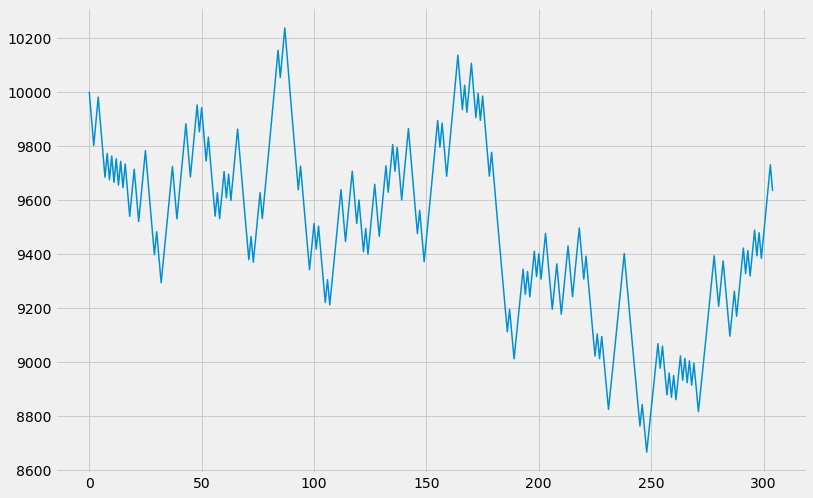

min balance: 8666.134817478138 
max balance: 10236.030810330489 
final balance: 9535.86291481906 
win percentage 51.800000000000004


,index,GAME_DATE,spread,home_cover,model_pred,model_probability,bet_won,bankroll_i,bankroll_n,bet_size
0,12808,2017-11-28,-1.0,0,1,0.616531,0,10000.000000,9900.000000,100.000000
1,12811,2017-11-29,-6.5,0,1,0.786205,0,9900.000000,9801.000000,99.000000
2,12812,2017-11-29,-7.5,1,1,0.802079,1,9801.000000,9890.100000,98.010000
3,12824,2017-12-01,-2.0,1,1,0.614217,1,9890.100000,9980.010000,98.901000
4,12829,2017-12-01,-7.0,0,1,0.810726,0,9980.010000,9880.209900,99.800100
...,...,...,...,...,...,...,...,...,...,...
300,15946,2020-08-22,-5.0,1,1,0.635413,1,9468.882536,9554.963286,94.688825
301,15956,2020-08-24,-6.5,1,1,0.623871,1,9554.963286,9641.826589,95.549633
302,15959,2020-08-29,-5.0,1,1,0.651690,1,9641.826589,9729.479558,96.418266
303,15960,2020-08-29,-14.0,0,1,0.614068,0,9729.479558,9632.184762,97.294796


In [264]:
select_bets = betting_results.loc[(betting_results['model_probability'] > 0.61) |
                                 (betting_results['model_probability'] < 0.38)]
simulate_bets(select_bets)

In [231]:
cond_list = [
    abs(betting_results['model_probability'] - 0.5).between(0, 0.05),
    abs(betting_results['model_probability'] - 0.5).between(0.05, 0.1),
    abs(betting_results['model_probability'] - 0.5) > 0.1
]
choices = [1,2,3]

betting_results['units'] = np.select(cond_list, choices)

betting_results


,GAME_DATE,spread,home_cover,model_pred,model_probability,bet_won,bankroll_i,bankroll_n,bet_size,units
10776,2017-12-20,-5.5,1,0,0.427335,0,NaN,NaN,NaN,2
10777,2017-12-20,-9.0,0,0,0.456759,1,NaN,NaN,NaN,1
10778,2017-12-20,-5.5,1,0,0.474228,0,NaN,NaN,NaN,1
10779,2017-12-20,-9.5,1,0,0.470551,0,NaN,NaN,NaN,1
10780,2017-12-21,2.0,1,1,0.561693,1,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...
13466,2020-09-15,-7.5,0,1,0.548545,0,NaN,NaN,NaN,1
13467,2020-09-20,-7.5,0,1,0.598595,0,NaN,NaN,NaN,2
13468,2020-09-25,-3.5,1,0,0.475931,0,NaN,NaN,NaN,1
13469,2020-10-04,9.5,1,0,0.487157,0,NaN,NaN,NaN,1


In [41]:
def simulate_bets_weighted_by_prob(df):
    df = df.reset_index()
    df.loc[0, 'bankroll_i'] = 10000
    for idx in df.index:
        if np.isnan(df.loc[idx, 'bankroll_i']):
            df.loc[idx, 'bankroll_i'] = df.loc[idx-1, 'bankroll_n']
            
        df.loc[idx, 'bet_size'] = df.loc[idx, 'bankroll_i'] * 0.01 * df.loc[idx, 'units']
        if df.loc[idx, 'bet_won'] == 1:
            df.loc[idx, 'bankroll_n'] = df.loc[idx, 'bankroll_i'] + (1/1.1)*df.loc[idx, 'bet_size']
        elif df.loc[idx, 'bet_won'] == 0:
            df.loc[idx, 'bankroll_n'] = df.loc[idx, 'bankroll_i'] - df.loc[idx, 'bet_size']
        else:
            df.loc[idx, 'bankroll_n'] = df.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(df.shape[0]), df['bankroll_i'], linewidth=1.5)            
    plt.show()
    min_balance = df['bankroll_n'].min()
    max_balance = df['bankroll_n'].max()
    final_balance = df['bankroll_n'].iloc[-1]
    win_pct = df.loc[df['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return df

In [329]:
# Find ranges of model probability where the win percentage is higher than 52.8
ranges = []
win_percentages = []
for i in range(1, 20):
    for j in range(1, 20):
        select_bets = betting_results.loc[(betting_results['model_probability'] > 0.5 + i/100)
                                          | (betting_results['model_probability'] < 0.5 - j/100)]
        
        win_pct = select_bets['bet_won'].mean()
        ranges.append((0.5-j/100, 0.5+i/100))
        win_percentages.append(win_pct)
        
prob_ranges = pd.DataFrame({'probability_range':ranges, 'win_percentage':win_percentages})
prob_ranges

,probability_range,win_percentage
0,"(0.49, 0.51)",0.504462
1,"(0.48, 0.51)",0.505213
2,"(0.47, 0.51)",0.505175
3,"(0.46, 0.51)",0.506992
4,"(0.45, 0.51)",0.505081
...,...,...
356,"(0.35, 0.69)",0.448529
357,"(0.33999999999999997, 0.69)",0.438776
358,"(0.32999999999999996, 0.69)",0.451220
359,"(0.32, 0.69)",0.569231


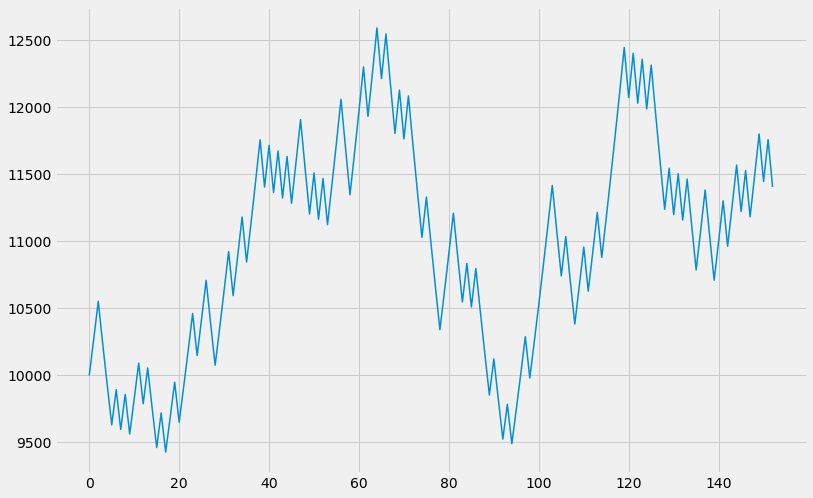

min balance: 9428.262704671131 
max balance: 12592.846433394563 
final balance: 11064.692263560595 
win percentage 54.25


In [233]:
select_bets = betting_results.loc[((betting_results['model_probability'] > 0.61)
                                 |(betting_results['model_probability'] < 0.38))]


results = simulate_bets_weighted_by_prob(select_bets)

In [327]:
spread_range = []
win_percentages = []

for i in range(1, 20):
    for j in range(0, i):
        select_bets = betting_results.loc[(abs(betting_results['spread']) > j)
                                         & (abs(betting_results['spread']) <= i)]
        
        win_pct = select_bets['bet_won'].mean()
        spread_range.append((j, i))
        win_percentages.append(win_pct)
        
spread_win_pcts = pd.DataFrame({'spread_range':spread_range, 'win_percentage':win_percentages})
spread_win_pcts.sort_values('win_percentage', ascending=False).head(20)        

,spread_range,win_percentage
152,"(16, 17)",1.000000
169,"(16, 18)",0.857143
151,"(15, 17)",0.692308
168,"(15, 18)",0.666667
187,"(16, 19)",0.600000
35,"(7, 8)",0.577061
34,"(6, 8)",0.556281
186,"(15, 19)",0.555556
43,"(7, 9)",0.546139
42,"(6, 9)",0.543353


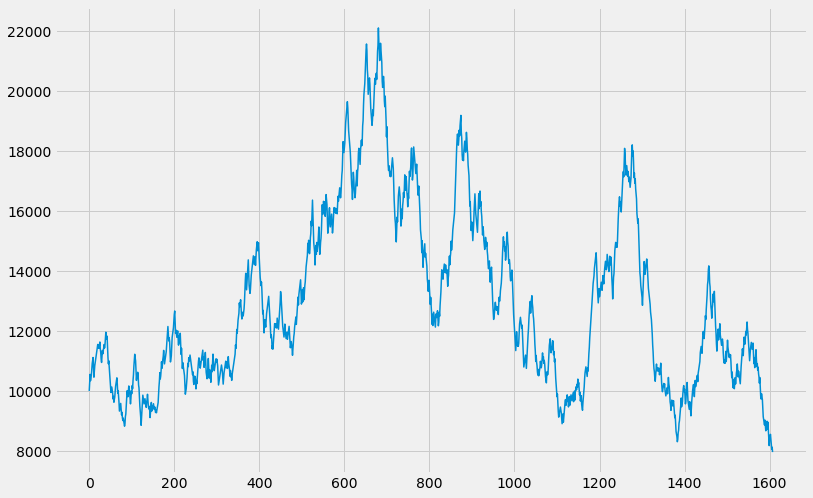

min balance: 7958.5716944036585 
max balance: 22117.950998050565 
final balance: 8030.922346170964 
win percentage 53.23


,index,GAME_DATE,spread,home_cover,model_pred,model_probability,bet_won,bankroll_i,bankroll_n,bet_size,units
0,14901,2018-11-10,5.5,0,0,0.391293,1,10000.000000,10272.727273,300.000000,3
1,14902,2018-11-10,5.5,0,0,0.391293,1,10272.727273,10552.892562,308.181818,3
2,14903,2018-11-10,-9.0,1,0,0.404800,0,10552.892562,10341.834711,211.057851,2
3,14914,2018-11-11,-2.5,1,1,0.548132,1,10341.834711,10435.851390,103.418347,1
4,14916,2018-11-11,-2.5,1,1,0.548132,1,10435.851390,10530.722766,104.358514,1
...,...,...,...,...,...,...,...,...,...,...,...
1603,18611,2020-08-13,-8.5,1,0,0.405775,0,8379.664139,8212.070856,167.593283,2
1604,18617,2020-08-14,-2.5,0,1,0.597242,0,8212.070856,8047.829439,164.241417,2
1605,18618,2020-08-14,2.5,1,1,0.508004,1,8047.829439,8120.991525,80.478294,1
1606,18621,2020-08-14,-2.5,0,1,0.597242,0,8120.991525,7958.571694,162.419830,2


In [347]:
select_bets = betting_results.loc[(((abs(betting_results['spread']) > 5)
                    & (abs(betting_results['spread']) <= 9))
                    | ((abs(betting_results['spread']) > 2)
                      & (abs(betting_results['spread']) <= 3)))]

simulate_bets_weighted_by_prob(select_bets)

## Random Forest 

In [265]:
rf = RandomForestClassifier()

rf.fit(X_train, cover_train)
rf.score(X_test, cover_test)

0.49843847595252966

In [46]:
cover_train.isnull().sum()

0

## SVC

In [47]:
svc = SVC()

pipeline = Pipeline([('scaler', StandardScaler()),
                    ('svc', SVC())])

search_spaces = {'svc__C': Real(1e-4, 1e+4, prior='log-uniform'),
              'svc__gamma': Real(1e-6, 1e+1, prior='log-uniform')
                }  

gs_svc = BayesSearchCV(pipeline, search_spaces=search_spaces, cv=tscv, verbose=3, n_jobs=-1, scoring='roc_auc')

gs_svc.fit(X_train, cover_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.8s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.4s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.2s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.3s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.6s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.6s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.2s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.9s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.6s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.0s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.4s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.0s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.3s remaining:   20.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.5s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.1s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.7s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.0s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.6s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.2s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.0s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.3s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.6s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.6s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.0s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.4s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.8s remaining:   29.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 25.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.0s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.3s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.2s remaining:   15.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


BayesSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('svc', SVC())]),
              n_jobs=-1, scoring='roc_auc',
              search_spaces={'svc__C': Real(low=0.0001, high=10000.0, prior='log-uniform', transform='identity'),
                             'svc__gamma': Real(low=1e-06, high=10.0, prior='log-uniform', transform='identity')},
              verbose=3)

In [48]:
print("best_SVC_params:", gs_svc.best_estimator_)

best_SVC_params: Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=1134.483113608219, gamma=1.7485330214979689e-06))])


In [50]:
best_svc = SVC(C=1134.483113608219, gamma=1.7485330214979689e-06, probability=True)
best_svc.fit(X_train, cover_train)
svc_acc = best_svc.score(X_test, cover_test)
print("SVC Accuracy:", svc_acc)
svc_preds = best_svc.predict(X_test)
svc_probs = best_svc.predict_proba(X_test)


SVC Accuracy: 0.5131168019987508


In [53]:
betting_results = final_df[['GAME_DATE', 'spread', 'home_cover']].iloc[cutoff:]
betting_results['model_pred'] = svc_preds
betting_results['model_probability'] = svc_probs[:, 1]
betting_results['bet_won'] = (betting_results['home_cover'] == betting_results['model_pred']).astype(int)

betting_results['bankroll_i'] = np.nan
betting_results['bankroll_n'] = np.nan
betting_results['bet_size'] = np.nan




In [54]:
# Find ranges of model probability where the win percentage is higher than 52.8
ranges = []
win_percentages = []
num_games_bet = []
for i in range(1, 41, 3):
    for j in range(1, 41, 3):
        select_bets = betting_results.loc[(betting_results['model_probability'] > 0.5 + i/100)
                                          | (betting_results['model_probability'] < 0.5 - j/100)]
        
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        ranges.append((0.5-j/100, 0.5+i/100))
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)

probability_ranges = pd.DataFrame({'ranges':ranges, 
                                   'num_games_bet':num_games_bet, 
                                   'win_percentage':win_percentages})

In [55]:
probability_ranges.sort_values('win_percentage', ascending=False, inplace=True)
probability_ranges.loc[probability_ranges['win_percentage'] > 0.52]

,ranges,num_games_bet,win_percentage
125,"(0.09999999999999998, 0.75)",3,0.666667
93,"(0.21999999999999997, 0.69)",6,0.666667
120,"(0.25, 0.75)",3,0.666667
121,"(0.21999999999999997, 0.75)",3,0.666667
122,"(0.19, 0.75)",3,0.666667
123,"(0.15999999999999998, 0.75)",3,0.666667
124,"(0.13, 0.75)",3,0.666667
119,"(0.28, 0.75)",3,0.666667
97,"(0.09999999999999998, 0.69)",6,0.666667
96,"(0.13, 0.69)",6,0.666667


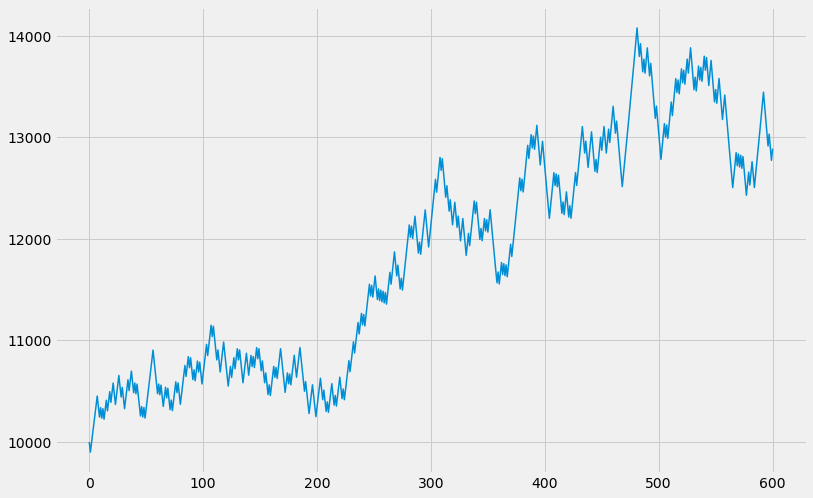

min balance: 9900.0 
max balance: 14076.686506035585 
final balance: 13005.72699159269 
win percentage 54.910000000000004


,index,GAME_DATE,spread,home_cover,model_pred,model_probability,bet_won,bankroll_i,bankroll_n,bet_size
0,12807,2017-11-28,-4.0,1,0,0.459649,0,10000.000000,9900.000000,100.000000
1,12810,2017-11-29,-5.5,0,0,0.438771,1,9900.000000,9990.000000,99.000000
2,12836,2017-12-02,-11.5,0,0,0.457072,1,9990.000000,10080.818182,99.900000
3,12842,2017-12-03,-12.0,0,0,0.459643,1,10080.818182,10172.461983,100.808182
4,12844,2017-12-04,-1.0,0,0,0.455559,1,10172.461983,10264.938911,101.724620
...,...,...,...,...,...,...,...,...,...,...
596,16001,2020-10-02,-11.0,0,0,0.433396,1,12914.374114,13031.777515,129.143741
597,16002,2020-10-04,9.5,1,0,0.368867,0,13031.777515,12901.459740,130.317775
598,16003,2020-10-06,7.5,1,0,0.369809,0,12901.459740,12772.445142,129.014597
599,16004,2020-10-09,-7.5,0,0,0.405355,1,12772.445142,12888.558280,127.724451


In [56]:
select_bets = betting_results.loc[~betting_results['model_probability'].between(0.46, 0.69)]
select_bets
simulate_bets(select_bets)

## XGBoost

[11386, 12594, 13789, 15002]
season 2015
train_accuracy: 0.9864746179518707 test_accuracy: 0.4859271523178808


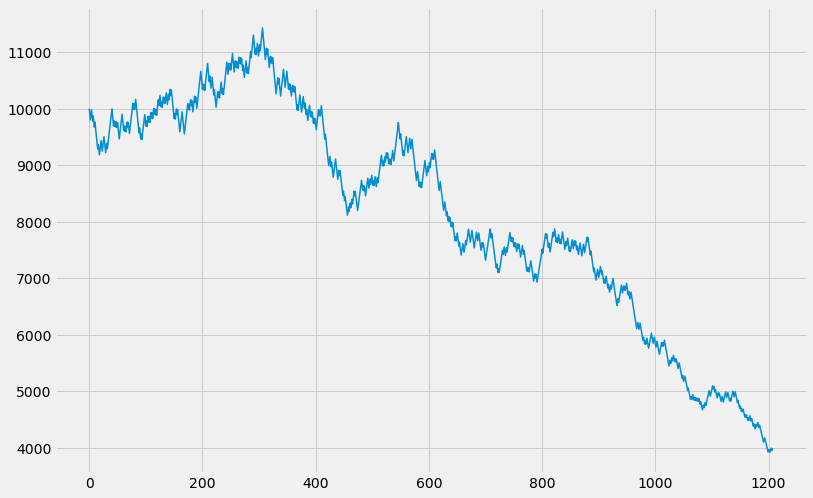

min balance: 3921.723177496321 
max balance: 11427.367228457484 
final balance: 3949.4644133450925 
win percentage 48.59
season 2016
train_accuracy: 0.9726060028585041 test_accuracy: 0.5230125523012552


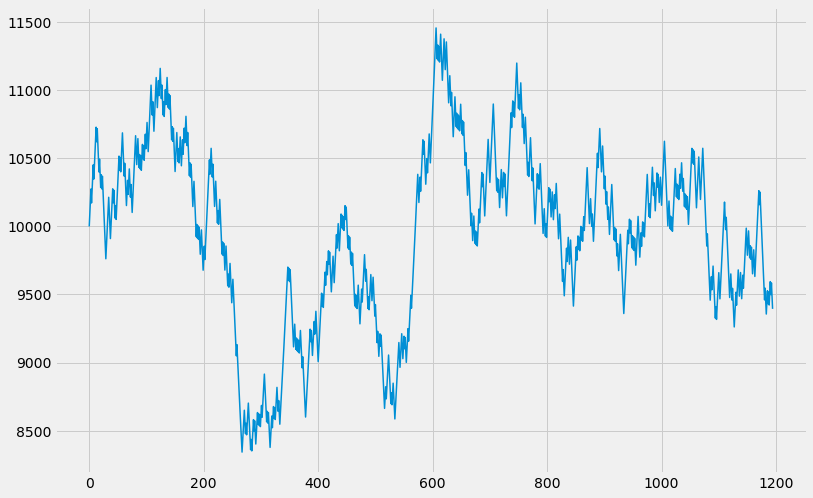

min balance: 8341.706986159224 
max balance: 11458.564406570351 
final balance: 9300.246046730384 
win percentage 52.300000000000004
season 2017
train_accuracy: 0.9748350134164914 test_accuracy: 0.5127782357790602


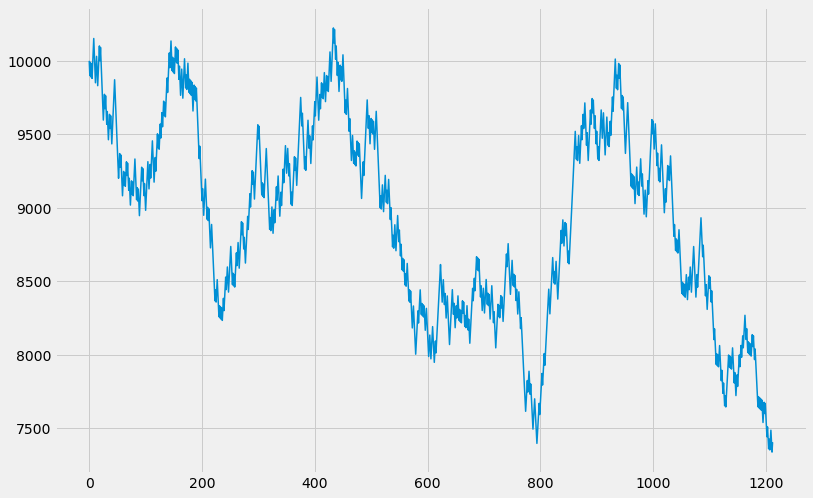

min balance: 7328.964938293876 
max balance: 10223.9081408989 
final balance: 7328.964938293876 
win percentage 51.28
season 2018
train_accuracy: 0.9653379549393414 test_accuracy: 0.49203187250996017


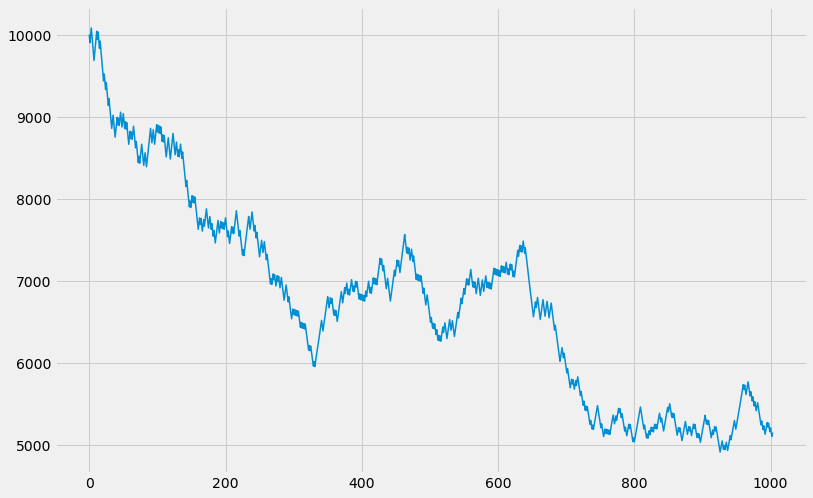

min balance: 4908.90651200181 
max balance: 10080.818181818182 
final balance: 5194.147726250351 
win percentage 49.2


[      index  GAME_DATE  spread  home_cover  model_pred  model_probability  \
 0     11386 2016-11-04     3.5           0           1           0.551248   
 1     11387 2016-11-04    11.5           1           0           0.136973   
 2     11388 2016-11-04    -2.5           0           0           0.489935   
 3     11389 2016-11-05    -3.5           1           1           0.880996   
 4     11390 2016-11-05    -3.0           1           0           0.285961   
 ...     ...        ...     ...         ...         ...                ...   
 1203  12589 2017-06-01    -7.5           1           1           0.628336   
 1204  12590 2017-06-04    -9.0           1           1           0.974724   
 1205  12591 2017-06-07     3.0           0           1           0.822771   
 1206  12592 2017-06-09     5.0           1           1           0.777002   
 1207  12593 2017-06-12    -9.5           0           1           0.695923   
 
       bet_won    bankroll_i   bankroll_n    bet_size  
 0    

In [283]:
cutoff_16 = int(final_df[final_df['SEASON_YEAR'] == '2016-17'].index[0])
cutoff_17 = int(final_df[final_df['SEASON_YEAR'] == '2017-18'].index[0])
cutoff_18 = int(final_df[final_df['SEASON_YEAR'] == '2018-19'].index[0])
cutoff_19 = int(final_df[final_df['SEASON_YEAR'] == '2019-20'].index[0])

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19]
print(cutoffs)
def train_model(features, cutoffs, estimator, prob_thresholds=(0.5, 0.5)):

    cover = final_df['home_cover']
    
    result_dfs = []
    
    for i in range(len(cutoffs)):
        if i == len(cutoffs) - 1:
            X_train = features.iloc[:cutoffs[i], :]
            X_test = features.iloc[cutoffs[i]:, :]
            cover_train = cover.iloc[:cutoffs[i]]
            cover_test = cover.iloc[cutoffs[i]:]
        else:
            X_train = features.iloc[:cutoffs[i], :]
            X_test = features.iloc[cutoffs[i]:cutoffs[i+1], :]
            cover_train = cover.iloc[:cutoffs[i]]
            cover_test = cover.iloc[cutoffs[i]:cutoffs[i+1]]
        

        estimator.fit(X_train, cover_train)
        preds = estimator.predict(X_test)
        probs = estimator.predict_proba(X_test)

        train_accuracy = estimator.score(X_train, cover_train)
        test_accuracy = estimator.score(X_test, cover_test)
        print("season {}".format(i+2015))
        print("train_accuracy:", train_accuracy, "test_accuracy:", test_accuracy)
                
        if i == len(cutoffs) - 1:
            betting_results = final_df[['GAME_DATE', 'spread', 'home_cover']].iloc[cutoffs[i]:]
            
        else:
            betting_results = final_df[['GAME_DATE', 'spread', 'home_cover']].iloc[cutoffs[i]:cutoffs[i+1]]
            
        betting_results['model_pred'] = preds
        betting_results['model_probability'] = probs[:, 1]
        betting_results['bet_won'] = (betting_results['home_cover'] == betting_results['model_pred']).astype(int)

        betting_results['bankroll_i'] = np.nan
        betting_results['bankroll_n'] = np.nan
        betting_results['bet_size'] = np.nan

        select_bets = betting_results.loc[((betting_results['model_probability'] > prob_thresholds[1])
                                         |(betting_results['model_probability'] < prob_thresholds[0]))]
        
        results = simulate_bets(select_bets)
        result_dfs.append(results)
    return result_dfs

train_model(features=features,
           cutoffs=cutoffs,
           estimator=xgb.XGBClassifier())

In [273]:
xgbc = xgb.XGBClassifier()
xgbc.fit(X_train, cover_train)
xgbc.score(X_test, cover_test)

0.5124921923797626

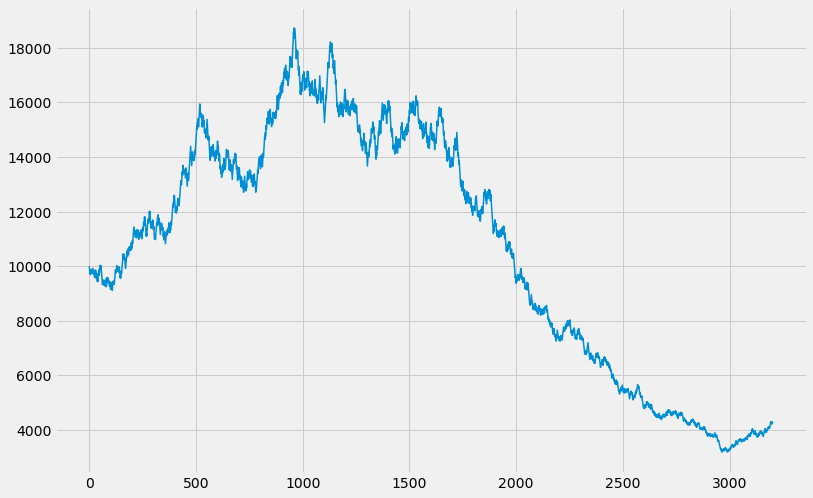

min balance: 3192.1367331235724 
max balance: 18730.531116838796 
final balance: 4326.638505591525 
win percentage 51.24999999999999


,index,GAME_DATE,spread,home_cover,model_pred,model_probability,bet_won,bankroll_i,bankroll_n,bet_size
0,12804,2017-11-28,-5.0,0,1,0.883982,0,10000.000000,9900.000000,100.000000
1,12805,2017-11-28,6.5,0,1,0.525432,0,9900.000000,9801.000000,99.000000
2,12806,2017-11-28,1.0,1,1,0.592982,1,9801.000000,9890.100000,98.010000
3,12807,2017-11-28,-4.0,1,0,0.415584,0,9890.100000,9791.199000,98.901000
4,12808,2017-11-28,-1.0,0,1,0.691953,0,9791.199000,9693.287010,97.911990
...,...,...,...,...,...,...,...,...,...,...
3197,16001,2020-10-02,-11.0,0,0,0.092810,1,4214.967613,4253.285500,42.149676
3198,16002,2020-10-04,9.5,1,1,0.705153,1,4253.285500,4291.951732,42.532855
3199,16003,2020-10-06,7.5,1,0,0.413315,0,4291.951732,4249.032215,42.919517
3200,16004,2020-10-09,-7.5,0,0,0.256874,1,4249.032215,4287.659780,42.490322


In [277]:
xgb_preds = xgbc.predict(X_test)
xgb_probs = xgbc.predict_proba(X_test)

betting_results = final_df[['GAME_DATE', 'spread', 'home_cover']].iloc[cutoff:]
betting_results['model_pred'] = xgb_preds
betting_results['model_probability'] = xgb_probs[:, 1]
betting_results['bet_won'] = (betting_results['home_cover'] == betting_results['model_pred']).astype(int)

betting_results['bankroll_i'] = np.nan
betting_results['bankroll_n'] = np.nan
betting_results['bet_size'] = np.nan

simulate_bets(betting_results)

In [286]:
search_spaces = {'min_child_weight':Integer(1,8),
              'gamma': Real(0.5, 3),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 12),
              'reg_lambda': Integer(1, 10),
              'reg_alpha': Integer(0, 10)}
    
    
xgb_bs = BayesSearchCV(xgb.XGBClassifier(), search_spaces=search_spaces, cv=tscv, verbose=3, n_jobs=-1)

xgb_bs.fit(X_train, cover_train)

print(xgb_bs.best_estimator_)
print("accuracy:", xgb_bs.score(X_test, cover_test))


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.5s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.3s remaining:   15.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.0s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.7s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.1s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.9s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.5s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.0s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.5s remaining:   23.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.4s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.1s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.0s remaining:   19.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.3s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.6s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.5s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.6s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.8s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.0s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.3s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.2s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.5s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.8s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.8s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.3s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.6s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.2s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.5s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.3s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.2s remaining:   22.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.2s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.3s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.3s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=2.915966678348526,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=8, reg_lambda=3, scale_pos_weight=1,
              subsample=0.7542126169173986, tree_method='exact',
              validate_parameters=1, verbosity=None)
accuracy: 0.5156152404747033


Using Accuracy as Metric:
accuracy = 0.5156
xgb_bs.best_estimator_


## Neural Network

In [287]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [346]:
features = final_df.iloc[:, 13:-1]
features = features.drop(columns=['home_rating_n', 'away_rating_n'])

cover = final_df['home_cover']

cutoff = int(final_df.shape[0] * 0.8)
X_train = features.iloc[:cutoff, :]
X_test = features.iloc[cutoff:, :]
cover_train = cover.iloc[:cutoff]
cover_test = cover.iloc[cutoff:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [351]:
class TeamMatchupDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.Tensor(features)
        self.targets = torch.Tensor(targets.values.reshape(-1, 1))
        
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, index):
        X = self.features[index]
        y = self.targets[index]
        return X, y

In [384]:
def get_accuracy(y_pred, y_test):
    y_pred = torch.round(torch.sigmoid(y_pred))
    
    correct_results_sum = (y_pred == y_test).sum().float()
    print("num_correct_results:", correct_results_sum)
    print("num_tests_examples:", y_test.shape[0])
    acc = correct_results_sum / y_test.shape[0]
    
    return acc

get_accuracy(torch.Tensor([1,1,0,0,0,0]), torch.Tensor([1,1,1,1,1,1]))

num_correct_results: tensor(2.)
num_tests_examples: 6


tensor(0.3333)

In [428]:
def get_num_correct(y_pred, y_test):
    y_pred = torch.round(torch.sigmoid(y_pred))
    
    num_correct_results = (y_pred == y_test).sum().float()
    return num_correct_results
get_num_correct(torch.Tensor([1,1,0,0,0,0]), torch.Tensor([1,1,1,1,1,1]))

tensor(2.)

In [426]:
data, targets = next(iter(test_loader))

test_loader.batch_sampler
X_test.shape[0]

3202

In [438]:
batch_size = 64

train_set = TeamMatchupDataset(X_train, cover_train)
test_set = TeamMatchupDataset(X_test, cover_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

data, targets = next(iter(train_loader))

print(data.shape, targets.shape)

net = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.BatchNorm1d(128),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.BatchNorm1d(64),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.BatchNorm1d(32),
    nn.Linear(32, 1))

print(net)

learning_rate = 0.0005
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.BCEWithLogitsLoss()
epochs = 35

# Training Loop
train_losses = []
test_losses = []
for e in range(epochs):
    train_loss = 0
    test_loss = 0
    correct_test_preds = 0
    net.train()
    for data, targets in train_loader:
        net.zero_grad()
        
        output = net(data)
        loss = loss_function(output, targets)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss)
    
    net.eval()
    with torch.no_grad():
        
        for test_data, test_targets in test_loader:
            output = net(test_data)
            loss = loss_function(output, test_targets)

            test_loss += loss.item()
            
            num_correct = get_num_correct(output, test_targets)
            
            correct_test_preds += num_correct
        test_losses.append(test_loss)
    
    print("epoch: {}... train_loss: {}... test_loss: {}... test_accuracy: {}".format(e, train_loss, test_loss, correct_test_preds/X_test.shape[0]))

torch.Size([64, 173]) torch.Size([64, 1])
Sequential(
  (0): Linear(in_features=173, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25, inplace=False)
  (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.25, inplace=False)
  (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Linear(in_features=64, out_features=32, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.25, inplace=False)
  (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=32, out_features=1, bias=True)
)
epoch: 0... train_loss: 143.4428926706314... test_loss: 35.632400929927826... test_accuracy: 0.500312328338623
epoch: 1... train_loss: 141.0815041065216... test_loss: 35.564949095249176... test_accuracy: 0.5112429857254028
epoch: 2... train_loss: 139.62377601861954... test_loss: 35.380755

In [439]:
test_outputs = net(torch.Tensor(X_test))
test_probs = torch.sigmoid(test_outputs)
test_preds = torch.round(test_probs)
test_preds

tensor([[1.],
        [1.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward>)

In [440]:
(test_preds.detach().numpy() == cover_test.values.reshape(-1, 1)).mean()
# # cover_test.shape, test_preds.shape

# cover_test.values.reshape(-1, 1)
# test_preds.detach().numpy()

0.5021861336664585

In [441]:
get_accuracy(test_probs, torch.Tensor(cover_test.values))

num_correct_results: tensor(5023938.)
num_tests_examples: 3202


tensor(1569.)

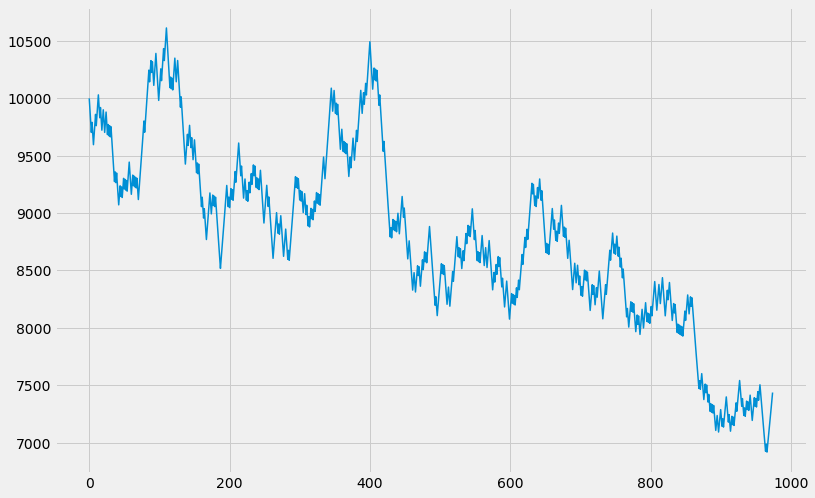

min balance: 6916.739306608499 
max balance: 10613.837803204755 
final balance: 7361.714164581637 
win percentage 50.970000000000006


,index,GAME_DATE,spread,home_cover,model_pred,model_probability,bet_won,bankroll_i,bankroll_n,bet_size
0,12804,2017-11-28,-5.0,0,1.0,0.703622,0,10000.000000,9900.000000,100.000000
1,12809,2017-11-29,-7.5,0,1.0,0.719094,0,9900.000000,9801.000000,99.000000
2,12811,2017-11-29,-6.5,0,1.0,0.828727,0,9801.000000,9702.990000,98.010000
3,12812,2017-11-29,-7.5,1,1.0,0.917854,1,9702.990000,9791.199000,97.029900
4,12815,2017-11-29,-11.0,1,0.0,0.345543,0,9791.199000,9693.287010,97.911990
...,...,...,...,...,...,...,...,...,...,...
970,15996,2020-09-23,3.5,1,1.0,0.683796,1,7171.707721,7236.905064,71.717077
971,15999,2020-09-27,3.0,1,1.0,0.760874,1,7236.905064,7302.695110,72.369051
972,16002,2020-10-04,9.5,1,1.0,0.731906,1,7302.695110,7369.083248,73.026951
973,16003,2020-10-06,7.5,1,1.0,0.784844,1,7369.083248,7436.074914,73.690832


In [445]:
betting_results = final_df[['GAME_DATE', 'spread', 'home_cover']].iloc[cutoff:]
betting_results['model_pred'] = test_preds.detach().numpy()
betting_results['model_probability'] = test_probs.detach().numpy()
betting_results['bet_won'] = (betting_results['home_cover'] == betting_results['model_pred']).astype(int)

betting_results['bankroll_i'] = np.nan
betting_results['bankroll_n'] = np.nan
betting_results['bet_size'] = np.nan

select_bets = betting_results.loc[((betting_results['model_probability'] > 0.65)
                                 |(betting_results['model_probability'] < 0.35))]
simulate_bets(select_bets)

## Using the Model

In [172]:
def load_current_season_team_data(season):
    """Loads basic, advanced, and scoring boxscores from
    current season and merges them into one dataframe
    """
    basic_gls = pd.read_csv('../data/current_season_data/team_gamelogs_{}.csv'.format(season))

    adv_gls = pd.read_csv('../data/current_season_data/team_advanced_boxscores_{}.csv'.format(season))

    scoring_gls = pd.read_csv('../data/current_season_data/team_scoring_boxscores_{}.csv'.format(season))

    temp = pd.merge(basic_gls, adv_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['VIDEO_AVAILABLE', 'TEAM_ID_y', 
                                      'TEAM_NAME_y', 'TEAM_CITY', 
                                      'MIN_y', 'TEAM_ID_y',
                                      'TEAM_NAME_y', 'TEAM_CITY_y',
                                      'MIN_y'], errors='ignore')
    
    full_df['SEASON_YEAR'] = season
    
    full_df = full_df[['SEASON_YEAR', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV',
       'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM']]
    return full_df

df = load_current_season_team_data(season='2020-21')
df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM
0,2020-21,22020,1610612746,LAC,LA Clippers,22000002,2020-12-22,LAC @ LAL,W,240,44,93,0.473,14,40,0.350,14,19,0.737,11,29,40,22,10,3,16,29,116,7,109.1,111.5,103.2,104.8,5.9,6.7,0.500,1.38,15.8,0.269,0.750,0.490,15.043,15.4,0.548,0.572,1.0,0.198,106.00,104.0,86.67,104,0.491,0.570,0.430,0.517,0.086,0.362,0.138,0.121,0.138,0.431,0.433,0.567,0.643,0.357,0.500,0.500
1,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000002,2020-12-22,LAL vs. LAC,L,240,38,81,0.469,9,29,0.310,24,31,0.774,8,37,45,22,4,2,19,20,109,-7,103.2,104.8,109.1,111.5,-5.9,-6.7,0.579,1.16,16.2,0.250,0.731,0.510,17.986,18.3,0.525,0.576,1.0,0.199,106.00,104.0,86.67,104,0.509,0.642,0.358,0.532,0.183,0.248,0.110,0.220,0.174,0.349,0.586,0.414,0.556,0.444,0.579,0.421
2,2020-21,22020,1610612751,BKN,Brooklyn Nets,22000001,2020-12-22,BKN vs. GSW,W,240,42,92,0.457,15,35,0.429,26,32,0.813,13,44,57,24,11,7,20,22,125,26,110.5,111.6,86.8,88.4,23.8,23.2,0.571,1.20,16.0,0.315,0.719,0.534,17.687,17.9,0.538,0.589,1.0,0.201,113.60,112.0,93.33,112,0.650,0.620,0.380,0.432,0.064,0.360,0.224,0.208,0.184,0.368,0.481,0.519,0.733,0.267,0.571,0.429
3,2020-21,22020,1610612744,GSW,Golden State Warriors,22000001,2020-12-22,GSW @ BKN,L,240,37,99,0.374,10,33,0.303,15,23,0.652,13,34,47,26,6,6,18,24,99,-26,86.8,88.4,110.5,111.6,-23.8,-23.2,0.703,1.44,17.0,0.281,0.685,0.466,15.773,16.1,0.424,0.454,1.0,0.201,113.60,112.0,93.33,112,0.350,0.667,0.333,0.545,0.101,0.303,0.121,0.152,0.192,0.444,0.630,0.370,0.900,0.100,0.703,0.297
4,2020-21,22020,1610612764,WAS,Washington Wizards,22000013,2020-12-23,WAS @ PHI,L,240,39,85,0.459,13,27,0.481,16,23,0.696,5,35,40,28,7,4,20,26,107,-6,97.2,100.0,104.4,104.6,-7.3,-4.6,0.718,1.40,19.6,0.184,0.720,0.455,18.162,18.7,0.535,0.562,1.0,0.196,109.16,107.5,89.58,107,0.462,0.682,0.318,0.486,0.243,0.364,0.196,0.150,0.159,0.243,0.577,0.423,1.000,0.000,0.718,0.282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,2020-21,22020,1610612754,IND,Indiana Pacers,22000553,2021-03-04,IND vs. DEN,L,240,41,90,0.456,14,39,0.359,7,12,0.583,11,23,34,27,12,3,15,17,103,-10,103.7,107.3,116.4,116.5,-12.7,-9.2,0.659,1.80,19.7,0.283,0.714,0.455,15.109,15.6,0.533,0.541,1.0,0.198,98.16,96.5,80.42,96,0.423,0.567,0.433,0.524,0.078,0.408,0.194,0.068,0.175,0.447,0.481,0.519,1.000,0.000,0.659,0.341
1062,2020-21,22020,1610612763,MEM,Memphis Grizzlies,22000555,2021-03-04,MEM vs. MIL,L,240,40,101,0.396,8,34,0.235,23,24,0.958,17,39,56,21,13,8,12,20,111,-1,104.2,103.7,104.0,106.7,0.2,-2.9,0.525,1.75,14.5,0.323,0.727,0.513,11.261,11.2,0.436,0.497,1.0,0.199,107.12,106.0,88.33,107,0.506,0.663,0.337,0.577,0.090,0.216,0.234,0.207,0.108,0.486,0.500,0.500,0.625,0.375,0.525,0.475
1063,2020-21,22020,1610612749,MIL,Milwaukee Bucks,22000555,2021-03-04,MIL @ MEM,W,240,42,95,0.442,10,34,0.294,18,22,0.818,13,39,52,21,11,5,16,19,112,1,104.0,106.7,104.2,103.7,-0.2,2.9,0.500,1.31,14.8,0.273,0.677,0.487,14.859,15.2,0.495,0.535,1.0,0.199,107.12,106.0,88.33,105,0.494,0.642,0.358,0.571,0.036,0.268,0.143,0.161,0.161,0.536,0.406,0.594,0.800,0.200,0.500,0.500
1064,2020-21,22020,1610612748,MIA,Miami Heat,22000557,2021-03-04,MIA @ NOP,W,240,36,73,0.493,10,30,0.333,21,25,0.840,5,36,41,27,6,3,11,20,103,10,114.4,113.2,101.3,103.3,1

In [173]:
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = get_team_and_opp_avg(df1)
df1 = add_percentage_features(df1)
df1 = add_rest_days(df1)

new_cols = []
for col in df1.columns:
    if col.endswith('team'):
        col = col[:-5]
    
    new_cols.append(col)
df1.columns = new_cols
df1 = df1.loc[df1['HOME_GAME'] == 1]
df1

Progress: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
..\src\features\build_team_features.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['rest'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')


,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,point_diff,WL,MIN,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,POSS,PIE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM,OREB_PCT,DREB_PCT,REB_PCT,TS_PCT,EFG_PCT,AST_RATIO,TOV_PCT,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_opp,DREB_PCT_opp,REB_PCT_opp,TS_PCT_opp,EFG_PCT_opp,AST_RATIO_opp,TOV_PCT_opp,rest
2,2020-21,22020,1610612746,LAC,LA Clippers,22000031,2020-12-27,LAC vs. DAL,1,73,-51,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2020-21,22020,1610612746,LAC,LA Clippers,22000054,2020-12-29,LAC vs. MIN,1,124,23,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,2020-21,22020,1610612746,LAC,LA Clippers,22000061,2020-12-30,LAC vs. POR,1,128,23,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
7,2020-21,22020,1610612746,LAC,LA Clippers,22000105,2021-01-05,LAC vs. SAS,1,113,-3,0,240.0,0.714286,25.285714,50.285714,14.428571,34.571429,16.714286,20.571429,9.0,32.0,41.0,24.571429,7.285714,5.0,13.857143,23.428571,110.571429,2.0,111.671429,113.757143,109.742857,111.714286,1.90,2.028571,97.0,0.497143,11.0,11.714286,16.285714,38.714286,12.714286,11.857143,11.428571,2.285714,0.213559,0.775087,0.491438,0.618527,0.553030,25.331370,12.858582,240.0,0.285714,25.857143,45.857143,12.0,36.714286,20.857143,26.0,9.285714,33.142857,42.428571,22.714286,5.714286,3.0,14.428571,18.285714,108.571429,-2.0,109.742857,111.714286,111.671429,113.757143,-1.90,-2.028571,97.428571,0.502857,9.714286,11.428571,15.142857,41.142857,13.571429,11.428571,7.857143,3.285714,0.224913,0.786441,0.508562,0.614847,0.531142,23.313783,13.305580,2.0
10,2020-21,22020,1610612746,LAC,LA Clippers,22000142,2021-01-10,LAC vs. CHI,1,130,3,1,240.0,0.600000,25.600000,50.200000,14.100000,34.200000,16.500000,19.500000,9.2,32.5,41.7,24.300000,6.900000,5.0,14.900000,22.200000,110.000000,0.8,111.270000,112.890000,110.360000,112.330000,0.90,0.560000,97.3,0.496100,11.6,10.900000,17.700000,38.600000,12.300000,12.600000,11.500000,1.800000,0.222760,0.777512,0.501805,0.620138,0.553910,24.974306,13.811643,240.0,0.400000,25.600000,47.400000,13.2,36.800000,18.400000,23.0,9.300000,32.100000,41.400000,23.200000,7.200000,2.9,14.100000,18.100000,109.200000,-0.8,110.360000,112.330000,111.270000,112.890000,-0.90,-0.560000,97.400000,0.503900,9.500000,13.400000,16.900000,41.000000,13.300000,11.500000,8.900000,3.700000,0.222488,0.777240,0.498195,0.611696,0.539192,23.819302,13.004981,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [174]:
df1.sort_values('GAME_DATE')

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,point_diff,WL,MIN,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,POSS,PIE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM,OREB_PCT,DREB_PCT,REB_PCT,TS_PCT,EFG_PCT,AST_RATIO,TOV_PCT,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_opp,DREB_PCT_opp,REB_PCT_opp,TS_PCT_opp,EFG_PCT_opp,AST_RATIO_opp,TOV_PCT_opp,rest
38,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000002,2020-12-22,LAL vs. LAC,1,109,-7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,2020-21,22020,1610612751,BKN,Brooklyn Nets,22000001,2020-12-22,BKN vs. GSW,1,125,26,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,2020-21,22020,1610612756,PHX,Phoenix Suns,22000004,2020-12-23,PHX vs. DAL,1,106,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,2020-21,22020,1610612741,CHI,Chicago Bulls,22000015,2020-12-23,CHI vs. ATL,1,104,-20,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
674,2020-21,22020,1610612754,IND,Indiana Pacers,22000011,2020-12-23,IND vs. NYK,1,121,14,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,2020-21,22020,1610612756,PHX,Phoenix Suns,22000185,2021-03-04,PHX vs. GSW,1,120,22,1,240.0,0.8,31.1,54.0,14.3,33.3,15.3,17.9,6.4,33.5,39.9,29.7,7.2,4.6,11.1,17.0,120.4,14.0,120.79,122.53,108.33,108.30,12.46,14.24,98.4,0.5704,11.9,15.3,18.1,49.5,17.9,12.4,11.3,2.7,0.162437,0.793839,0.488971,0.659813,0.601947,30.182927,10.444503,240.0,0.2,28.5,51.2,10.5,32.9,17.9,21.4,8.7,33.0,41.7,21.0,6.5,4.5,13.7,16.5,106.4,-14.0,108.33,108.30,120.79,122.53,-12.46,-14.24,98.3,0.4296,11.2,11.4,11.9,44.7,12.6,15.0,7.5,2.4,0.206161,0.837563,0.511029,0.599045,0.526159,21.363174,12.777944,2.0
955,2020-21,22020,1610612759,

In [148]:
prev_season_final_elo = {}
for team in full_df['TEAM_ABBREVIATION'].unique():
    team_df = full_df.loc[full_df['TEAM_ABBREVIATION'] == team].sort_values('GAME_DATE').reset_index(drop=True)
    final_elo = team_df.loc[team_df.shape[0]-1, 'home_rating_n']
    prev_season_final_elo[team] = final_elo
    
    
prev_season_final_elo

{'HOU': 1579.858475778707,
 'POR': 1503.5149379877623,
 'CHA': 1362.8777352946001,
 'PHX': 1522.3987178407065,
 'MIN': 1343.0163137535449,
 'LAC': 1662.9472489555571,
 'DAL': 1555.6941663957334,
 'MIL': 1679.9241786940884,
 'BKN': 1457.0658777245853,
 'CHI': 1317.3924432438212,
 'IND': 1567.1153866440147,
 'PHI': 1548.5036725162634,
 'NYK': 1295.1449046527694,
 'CLE': 1280.3237701967212,
 'SAS': 1531.9068419458897,
 'GSW': 1335.3787930772623,
 'SAC': 1474.1315778535457,
 'DET': 1354.3935876224127,
 'DEN': 1601.17421505412,
 'LAL': 1697.1499748850333,
 'OKC': 1582.8324655350702,
 'ATL': 1322.8474192461028,
 'MIA': 1640.4218181237568,
 'BOS': 1737.2655217515478,
 'UTA': 1586.21057029818,
 'TOR': 1726.494363766163,
 'WAS': 1345.1704523267028,
 'MEM': 1547.605627422138,
 'ORL': 1480.4119491320557,
 'NOP': 1511.1447525776366}

In [149]:
# Add ELO ratings

def get_current_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['TEAM_SCORE']
        away_score = home_score - row['point_diff']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[home_team_abbr] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return elo_dic

elo_ratings_dic = get_current_elo_ratings(df1, prev_season_final_elo)


progress:: 529it [00:00, 616.57it/s]


In [150]:
elo_ratings_dic

{'HOU': 1398.672071704217,
 'POR': 1517.034830230807,
 'CHA': 1443.3456732809802,
 'PHX': 1625.6057692479335,
 'MIN': 1268.4724736730518,
 'LAC': 1650.2711934785632,
 'DAL': 1549.9342044719624,
 'MIL': 1623.732478625895,
 'BKN': 1576.273585523611,
 'CHI': 1442.8234758599813,
 'IND': 1522.5866194835326,
 'PHI': 1575.9142414030405,
 'NYK': 1439.4906941690665,
 'CLE': 1356.2177606891892,
 'SAS': 1500.4625688681197,
 'GSW': 1485.2400026357552,
 'SAC': 1396.4624330492445,
 'DET': 1387.2760420987422,
 'DEN': 1625.7116783603244,
 'LAL': 1682.636696062764,
 'OKC': 1424.113009043379,
 'ATL': 1449.649554337936,
 'MIA': 1549.6870356869651,
 'BOS': 1585.4048199132708,
 'UTA': 1683.3391658143623,
 'TOR': 1583.1766213453748,
 'WAS': 1383.8524492478507,
 'MEM': 1531.8738834203928,
 'ORL': 1365.9391567698647,
 'NOP': 1525.038131726193}

In [151]:
X_train

,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_elo_pred,home_rating_i,away_rating_i,elo_MOV_pred,spread,away_decimal_avg,home_decimal_avg
0,240.0,0.600000,25.800000,53.400000,7.6,19.8,21.0,28.2,12.000000,30.000000,42.000000,21.4,8.8,3.400000,17.6,23.800000,95.400000,5.0,104.660000,104.50,99.360000,99.740000,5.320000,4.760000,91.400000,0.561800,18.200000,6.600000,18.400000,32.8,14.200000,11.200000,7.2,0.400000,0.314136,0.746269,0.535714,0.600725,0.508197,23.413567,17.052942,240.0,0.400000,28.0,58.800000,5.0,13.6,19.400000,26.400000,10.200000,26.2,36.400000,18.200000,6.000000,2.800000,17.000000,23.200000,90.400000,-5.0,99.360000,99.740000,104.660000,104.50,-5.320000,-4.760000,90.400000,0.438200,25.000000,9.2,16.800000,30.200000,13.600000,13.800000,4.2,0.2,0.253731,0.685864,0.464286,0.577946,0.490331,20.132743,16.829017,2.0,255.0,0.400000,30.400000,64.4,5.4,15.200000,24.400000,33.000000,12.600000,31.800000,44.4,17.800000,6.0,3.600000,19.2,28.6,101.400000,-6.6,100.640000,101.300000,106.020000,108.440000,-5.400000,-7.140000,100.0,0.4542,11.4,14.000000,16.800000,48.200000,13.200000,16.600000,4.400000,0.600000,0.298578,0.719457,0.513889,0.583698,0.483668,17.800000,16.943170,255.0,0.600000,33.400000,69.8,6.8,17.200000,20.800000,29.200000,12.4,29.6,42.0,20.6,7.600000,6.000000,14.600000,26.8,108.000000,6.6,106.020000,108.440000,100.640000,101.300000,5.400000,7.140000,99.800000,0.5458,19.4,13.000000,22.200000,46.800000,14.2,18.400000,5.800000,0.600000,0.280543,0.701422,0.486111,0.578010,0.501149,20.641283,12.756885,2.0,0.796747,1440.768175,1303.454329,8.48,-10.5,5.750000,1.166667
1,240.0,0.600000,30.000000,64.200000,6.4,19.6,19.6,25.4,14.600000,30.0000

In [175]:
df1.loc[df1['TEAM_ABBREVIATION'] == 'BKN']

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,point_diff,WL,MIN,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,POSS,PIE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM,OREB_PCT,DREB_PCT,REB_PCT,TS_PCT,EFG_PCT,AST_RATIO,TOV_PCT,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_opp,DREB_PCT_opp,REB_PCT_opp,TS_PCT_opp,EFG_PCT_opp,AST_RATIO_opp,TOV_PCT_opp,rest
75,2020-21,22020,1610612751,BKN,Brooklyn Nets,22000001,2020-12-22,BKN vs. GSW,1,125,26,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,2020-21,22020,1610612751,BKN,Brooklyn Nets,22000042,2020-12-28,BKN vs. MEM,1,111,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
79,2020-21,22020,1610612751,BKN,Brooklyn Nets,22000057,2020-12-30,BKN vs. ATL,1,145,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
80,2020-21,22020,1610612751,BKN,Brooklyn Nets,22000072,2021-01-01,BKN vs. ATL,1,96,-18,0,245.000000,0.600000,26.600000,51.200000,16.000000,38.800000,20.400000,25.600000,10.000000,37.200000,47.200000,25.200000,7.800000,6.200000,16.200000,21.000000,121.600000,10.200000,113.440000,114.520000,102.380000,104.620000,11.080000,9.920000,106.400000,0.563000,8.000000,14.600000,19.200000,44.000000,13.000000,12.600000,11.200000,3.800000,0.220264,0.701887,0.479675,0.635770,0.562222,23.684211,13.791460,245.000000,0.400000,30.000000,64.200000,11.200,33.800000,17.800000,24.600000,15.800000,35.400000,51.200000,26.200000,7.000000,4.000000,15.800000,22.4,111.400000,-10.200000,102.380000,104.620000,113.440000,114.520000,-11.080000,-9.920000,106.400000,0.437000,7.600000,12.600000,20.200000,51.600000,16.200000,13.000000,9.600000,1.400000,0.298113,0.779736,0.520325,0.538622,0.477551,24.624060,12.678136,2.0
81,2020-21,22020,1610612751,BKN,Brooklyn Nets,22000086,2021-01-03,BKN vs. WAS,1,122,-1,0,244.166667,0.500000,26.833333,50.833333,14.500000,38.500000,20.166667,25.166667,10.000000,36.833333,46.833333,24.166667,7.500000,6.166667,16.000000,20.166667,117.333333,5.500000,110.350000,111.433333,104.283333,106.383333,6.083333,5.066667,105.333333,0.539167,8.166667,13.166667,17.000000,44.166667,13.333333,12.500000,9.833333,3.666667,0.218182,0.712903,0.480342,0.618390,0.543843,22.943038,13.744917,244.166667,0.500000,29.500000,62.500000,12.000,34.666667,16.833333,22.833333,14.833333,35.833333,50.666667,25.833333,7.166667,3.833333,15.000000,22.0,111.833333,-5.500000,104.283333,106.383333,110.350000,111.433333,-6.083333,-5.066667,105.166667,0.460833,8.166667,12.000000,19.833333,49.833333,15.333333,13.333333,10.000000,1.833333,0.287097,0.781818,0.519658,0.547183,0.488851,24.564184,12.273620,2.0
82,2020-21,22020,1610612751,BKN,Brooklyn Nets,22000102,20

In [167]:
def create_matchup_row(df, away_team, home_team):
    home_team = df.loc[df['TEAM_ABBREVIATION'] == home_team].sort_values('GAME_DATE')
    away_team = df.loc[df['TEAM_ABBREVIATION'] == away_team].sort_values('GAME_DATE')
    
    home_cols = ["HOME_" + col for col in home_team.columns]
    away_cols = ["AWAY_" + col for col in away_team.columns]    
    home_cols.extend(away_cols)

    home_last = home_team.iloc[-1].values.reshape(1, -1)
    away_last = away_team.iloc[-1].values.reshape(1, -1)
    
    matchup_row = np.concatenate([home_last, away_last], axis=1)
    
    df_row = pd.DataFrame(matchup_row, columns = home_cols)
    
    df_row.drop(columns = [])
    
    return df_row

x = create_matchup_row(df1, 'GSW', 'BKN')
x

,HOME_SEASON_YEAR,HOME_SEASON_ID,HOME_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_TEAM_NAME,HOME_GAME_ID,HOME_GAME_DATE,HOME_MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_point_diff,HOME_WL,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_SEASON_YEAR,AWAY_SEASON_ID,AWAY_TEAM_ID,AWAY_TEAM_ABBREVIATION,AWAY_TEAM_NAME,AWAY_GAME_ID,AWAY_GAME_DATE,AWAY_MATCHUP,AWAY_HOME_GAME,AWAY_TEAM_SCORE,AWAY_point_diff,AWAY_WL,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest
0,2020-21,22020,1610612751,BKN,Brooklyn Nets,22000519,2021-02-27,BKN vs. DAL,1,98,-17,0,240,0.8,27.3,47.4,16.4,39,16,20.3,8,32.2,40.2,26.9,7.4,4.1,12.4,17.3,119.8,7.6,120.13,120.67,110.96,113.46,9.14,7.23,99.2,0.5269,7.7,13.4,15.9,45.8,14.5,12,11.7,4,0.201005,0.783455,0.49691,0.659212,0.600694,27.1169,11.51,240,0.2,31.2,55.8,12.2,33,13.2,17,8.9,31.8,40.7,24.7,6.9,4.6,13.9,15.5,112.2,-7.6,110.96,113.46,120.13,120.67,-9.14,-7.23,99,0.4731,10,12.5,13.5,51.7,14.8,15.5,9.1,2.6,0.216545,0.798995,0.50309,0.606224,0.557432,24.9495,12.6157,2,2020-21,22020,1610612744,GSW,Golden State Warriors,22000511,2021-02-26,GSW vs. CHA,1,130,9,1,242.5,0.6,27.1,48.3,14.5,39.8,17.1,20.8,7.4,35.4,42.8,28.2,8.3,5.2,14.9,19.4,114.8,5.4,109.59,110.9,103.19,105.75,6.4,5.12,103.5,0.5403,6.4,15,17.6,47.2,16.3,10.2,10.9,2.9,0.16895,0.771242,0.477146,0.619362,0.554484,27.2464,13.2855,242.5,0.4,26.6,57.5,13,33.8,17.2,20.3,10.5,36.4,46.9,23.7,7.5,4.3,16.2,19.6,109.4,-5.4,103.19,105.75,109.59,110.9,-6.4,-5.12,103.3,0.4597,9.5,10.7,15.7,42.9,12.9,12.8,10.1,2.4,0.228758,0.83105,0.522854,0.571184,0.504929,22.9429,13.9137,2


In [170]:
x.columns[90:110]

Index(['HOME_TS_PCT_opp', 'HOME_EFG_PCT_opp', 'HOME_AST_RATIO_opp',
       'HOME_TOV_PCT_opp', 'HOME_rest', 'AWAY_SEASON_YEAR', 'AWAY_SEASON_ID',
       'AWAY_TEAM_ID', 'AWAY_TEAM_ABBREVIATION', 'AWAY_TEAM_NAME',
       'AWAY_GAME_ID', 'AWAY_GAME_DATE', 'AWAY_MATCHUP', 'AWAY_HOME_GAME',
       'AWAY_TEAM_SCORE', 'AWAY_point_diff', 'AWAY_WL', 'AWAY_MIN',
       'AWAY_RECORD', 'AWAY_FG2M'],
      dtype='object')

In [164]:
a

[1, 2, 3, 4, 5]